# Installs & Imports

In [1]:
!pip install -q dask[dataframe] kaggle cma catboost category_encoders deap optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [2]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

In [3]:
# Test LightGBM GPU setup
import lightgbm as lgb
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10_000)
dtrain = lgb.Dataset(X, label=y)
bst = lgb.train(
    params={
        'objective': 'regression',
        'device': 'gpu',
        'verbose': 1
    },
    train_set=dtrain,
    num_boost_round=5
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 100
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (0.95 MB) transferred to GPU in 0.018586 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 1.032960


In [4]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer
)
from sklearn.base import clone
from sklearn.inspection import permutation_importance

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import joblib
from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm

import cma
from cma import CMAEvolutionStrategy, ScaleCoordinates

import xgboost
import lightgbm
import catboost

from category_encoders import TargetEncoder

import optuna
from optuna.exceptions import TrialPruned
from optuna.samplers import TPESampler

from deap import base, creator, tools, algorithms

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
pd.set_option('display.max_rows', None)

# Load the Data

In [5]:
def download_and_load_dataset(n_rows=5):
    """
    Download and extract the 'aswathrao/demand-forecasting' dataset from Kaggle.
    Load the 'train.csv' into a pandas DataFrame named 'df'.

    Parameters:
    - n_rows (int): Number of rows to display from the DataFrame.

    Returns:
    - df (pd.DataFrame): Loaded DataFrame.
    """
    dataset_name = "aswathrao/demand-forecasting"

    # Download the dataset
    print("Downloading the dataset from Kaggle...")
    !kaggle datasets download -d {dataset_name} -p /content

    # Unzip the dataset into a folder named 'demand-forecasting'
    zip_path = '/content/demand-forecasting.zip'
    extract_to = '/content/demand-forecasting'
    print("Extracting the dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Remove the zip file to save space
    os.remove(zip_path)

    # Iterate through the files in the dataset directory to find 'train.csv'
    for filename in os.listdir(extract_to):
        if 'train' in filename.lower() and filename.endswith('.csv'):
            original_path = os.path.join(extract_to, filename)
            new_path = '/content/train.csv'
            shutil.move(original_path, new_path)
            print(f"Renamed '{filename}' to 'train.csv'")
            break
    else:
        print("No file with 'train' found in the dataset directory.")
        return None

    # Load the train.csv into a pandas DataFrame
    print("Loading 'train.csv' into a DataFrame...")
    df = pd.read_csv('/content/train.csv')

    # Display the first few rows of the DataFrame
    print(f"\nFirst {n_rows} rows of train.csv:")
    display(df.head(n_rows))

    # Display the last few rows of the DataFrame
    print(f"\nLast {n_rows} rows of train.csv:")
    display(df.tail(n_rows))

    return df

In [6]:
# Download, extract, and load the dataset
df = download_and_load_dataset(n_rows=20)

Dataset URL: https://www.kaggle.com/datasets/aswathrao/demand-forecasting
License(s): unknown
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 155MB/s]
Extracting the dataset...
Renamed 'train_0irEZ2H.csv' to 'train.csv'
Loading 'train.csv' into a DataFrame...

First 20 rows of train.csv:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99



Last 20 rows of train.csv:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
150130,212616,09/07/13,9961,245387,355.5375,469.5375,1,1,91
150131,212617,09/07/13,9961,245338,356.9625,469.5375,1,0,127
150132,212619,09/07/13,9961,547934,141.7875,177.4125,0,0,13
150133,212622,09/07/13,9984,216418,87.6375,87.6375,0,0,52
150134,212623,09/07/13,9984,216419,86.9250,86.9250,0,0,27
150135,212624,09/07/13,9984,300021,86.2125,86.2125,0,0,10
150136,212626,09/07/13,9984,216425,131.1000,131.1000,0,0,32
150137,212627,09/07/13,9984,216233,130.3875,130.3875,0,0,26
150138,212628,09/07/13,9984,217390,170.2875,170.2875,0,0,30
150139,212632,09/07/13,9984,219009,194.5125,194.5125,0,0,85


# Explore the Data

In [7]:
def clean_and_engineer_date_features(df, n_rows=5):
    """
    Clean the 'week' variable by converting it to datetime and extracting day, month, year.

    Parameters:
    - df (pd.DataFrame): The DataFrame to clean and engineer features on.
    - n_rows (int): Number of rows to display from the DataFrame.

    Returns:
    - df (pd.DataFrame): DataFrame with new date features.
    """
    # Inspect the 'week' variable
    print("===== 'week' Variable Before Cleaning =====")
    display(df['week'].head())

    # Convert 'week' to datetime
    try:
        df['date'] = pd.to_datetime(df['week'], format='%d/%m/%y')
    except Exception as e:
        print(f"Error converting 'week' to datetime: {e}")
        print("Please verify the format of the 'week' column.")
        return df

    # Extract day, month, year, week_of_year, day_of_week
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

    # Create flags for start and end of year
    df['is_start_of_year'] = df['week_of_year'].apply(lambda x: 1 if x <= 4 else 0)
    df['is_end_of_year'] = df['week_of_year'].apply(lambda x: 1 if x >= 48 else 0)

    # Create 'week_of_month' feature
    def get_week_of_month(date):
        """
        Calculate the week of the month for a given date.

        Parameters:
        - date (pd.Timestamp): The date for which to calculate the week of the month.

        Returns:
        - int: The week of the month (1-based index).
        """
        first_day = date.replace(day=1)
        dom = date.day
        # Adjust the day of month by adding the weekday of the first day
        adjusted_dom = dom + first_day.weekday()
        # Calculate week number
        return int(np.ceil(adjusted_dom / 7.0))

    df['week_of_month'] = df['date'].apply(get_week_of_month)

    # Drop the original 'week' column as it's now redundant
    df = df.drop(['week'], axis=1)

    # Categorize variables
    categorical_cols = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku']

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

    # Display data types after conversion
    print("\n===== Data Types After Date Engineering =====")
    display(df.dtypes)

    print("\n")
    display(df.head(n_rows))
    print("\n")
    display(df.tail(n_rows))

    return df

In [8]:
# Execute the function
df = clean_and_engineer_date_features(df, n_rows=20)

===== 'week' Variable Before Cleaning =====


,week
0,17/01/11
1,17/01/11
2,17/01/11
3,17/01/11
4,17/01/11



===== Data Types After Date Engineering =====


,0
record_ID,category
store_id,category
sku_id,category
total_price,float64
base_price,float64
is_featured_sku,category
is_display_sku,category
units_sold,int64
date,datetime64[ns]
day,int32


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month
0,1,8091,216418,99.0375,111.8625,0,0,20,2011-01-17,17,1,2011,3,0,1,0,4
1,2,8091,216419,99.0375,99.0375,0,0,28,2011-01-17,17,1,2011,3,0,1,0,4
2,3,8091,216425,133.9500,133.9500,0,0,19,2011-01-17,17,1,2011,3,0,1,0,4
3,4,8091,216233,133.9500,133.9500,0,0,44,2011-01-17,17,1,2011,3,0,1,0,4
4,5,8091,217390,141.0750,141.0750,0,0,52,2011-01-17,17,1,2011,3,0,1,0,4
5,9,8091,219009,227.2875,227.2875,0,0,18,2011-01-17,17,1,2011,3,0,1,0,4
6,10,8091,219029,327.0375,327.0375,0,0,47,2011-01-17,17,1,2011,3,0,1,0,4
7,13,8091,223245,210.9000,210.9000,0,0,50,2011-01-17,17,1,2011,3,0,1,0,4
8,14,8091,223153,190.2375,234.4125,1,1,82,2011-01-17,17,1,2011,3,0,1,0,4
9,17,8095,216418,99.0375,99.0375,0,0,99,2011-01-17,17,1,2011,3,0,1,0,4


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month
150130,212616,9961,245387,355.5375,469.5375,1,1,91,2013-07-09,9,7,2013,28,1,0,0,2
150131,212617,9961,245338,356.9625,469.5375,1,0,127,2013-07-09,9,7,2013,28,1,0,0,2
150132,212619,9961,547934,141.7875,177.4125,0,0,13,2013-07-09,9,7,2013,28,1,0,0,2
150133,212622,9984,216418,87.6375,87.6375,0,0,52,2013-07-09,9,7,2013,28,1,0,0,2
150134,212623,9984,216419,86.9250,86.9250,0,0,27,2013-07-09,9,7,2013,28,1,0,0,2
150135,212624,9984,300021,86.2125,86.2125,0,0,10,2013-07-09,9,7,2013,28,1,0,0,2
150136,212626,9984,216425,131.1000,131.1000,0,0,32,2013-07-09,9,7,2013,28,1,0,0,2
150137,212627,9984,216233,130.3875,130.3875,0,0,26,2013-07-09,9,7,2013,28,1,0,0,2
150138,212628,9984,217390,170.2875,170.2875,0,0,30,2013-07-09,9,7,2013,28,1,0,0,2
150139,212632,9984,219009,194.5125,194.5125,0,0,85,2013-07-09,9,7,2013,28,1,0,0,2


In [9]:
def explore_data(df, top_n=10):
    """
    Perform comprehensive exploratory data analysis on the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to explore.
    - top_n (int): Number of top items to display in bar plot.
    """
    # Set plot styles for consistency and aesthetics
    sns.set(style='whitegrid')
    plt.rcParams['figure.figsize'] = (6, 4)
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8

    # 1. Basic Information
    print("===== Basic Information =====")
    df.info()
    print("\n")

    # 2. Descriptive Statistics for Numerical Features
    numerical_features = ['total_price', 'base_price', 'units_sold']
    print("===== Descriptive Statistics (Numerical Features) =====")
    if all(feature in df.columns for feature in numerical_features):
        display(df[numerical_features].describe())
    else:
        missing_feats = [feat for feat in numerical_features if feat not in df.columns]
        print(f"Missing numerical features: {missing_feats}")
    print("\n")

    # 3. Descriptive Statistics for Categorical Features
    categorical_features = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku']
    print("===== Descriptive Statistics (Categorical Features) =====")
    if all(feature in df.columns for feature in categorical_features):
        display(df[categorical_features].describe())
    else:
        missing_feats = [feat for feat in categorical_features if feat not in df.columns]
        print(f"Missing categorical features: {missing_feats}")
    print("\n")

    # 4. Number of Missing Values per Column
    print("===== Number of Missing Values per Column =====")
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        display(missing_values)
    else:
        print("No missing values detected.")
    print("\n")

    # 5. Histograms for Numerical Features
    print("===== Histograms for Numerical Features =====")
    for col in numerical_features:
        if col in df.columns:
            plt.figure()
            sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
            plt.title(f'Histogram of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 6. Boxplots for Numerical Features
    print("===== Boxplots for Numerical Features =====")
    for col in numerical_features:
        if col in df.columns:
            plt.figure()
            sns.boxplot(x=df[col], color='lightgreen')
            plt.title(f'Boxplot of {col}')
            plt.xlabel(col)
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 7. Correlation Heatmap for Numerical Features
    print("===== Correlation Heatmap (Numerical Features) =====")
    if all(feature in df.columns for feature in numerical_features):
        corr_matrix = df[numerical_features].corr()
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Numerical Features')
        plt.show()
    else:
        missing_feats = [feat for feat in numerical_features if feat not in df.columns]
        print(f"Cannot generate heatmap. Missing numerical features: {missing_feats}")
    print("\n")

    # 8. Unique Values for Categorical and Time-based Variables
    unique_features = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku',
                       'day', 'month', 'year', 'week_of_year', 'day_of_week',
                       'is_start_of_year', 'is_end_of_year', 'week_of_month']
    print("===== Unique Values for Categorical and Time-based Variables =====")
    for col in unique_features:
        if col in df.columns:
            unique_count = df[col].nunique()
            print(f"'{col}': {unique_count} unique values")
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 9. Boxplot of 'units_sold' by 'day', 'month', and 'year'
    print("===== Boxplot of 'units_sold' by Time-based Features =====")
    time_based_features = ['day', 'month', 'year']
    for time_col in time_based_features:
        if time_col in df.columns and 'units_sold' in df.columns:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df[time_col], y=df['units_sold'], palette='viridis')
            plt.title(f'Units Sold by {time_col.capitalize()}')
            plt.xlabel(time_col.capitalize())
            plt.ylabel('Units Sold')
            plt.show()
        else:
            print(f"Cannot plot boxplot for '{time_col}'. Column not found in DataFrame.")
    print("\n")

    # 10. Bar Plot of Total Units Sold per Month
    print("===== Bar Plot of Total Units Sold per Month =====")
    if 'month' in df.columns and 'units_sold' in df.columns:
        units_per_month = df.groupby('month')['units_sold'].sum().reset_index()
        # Ensure months are sorted correctly
        units_per_month = units_per_month.sort_values('month')
        plt.figure(figsize=(6, 4))
        sns.barplot(x='month', y='units_sold', data=units_per_month, palette='Blues_d')
        plt.title('Total Units Sold per Month')
        plt.xlabel('Month')
        plt.ylabel('Total Units Sold')
        plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.show()
    else:
        print("Columns 'month' and/or 'units_sold' not found in DataFrame.")
    print("\n")

    # 11. Bar Plot of Total Units Sold per Year
    print("===== Bar Plot of Total Units Sold per Year =====")
    if 'year' in df.columns and 'units_sold' in df.columns:
        units_per_year = df.groupby('year')['units_sold'].sum().reset_index()
        units_per_year = units_per_year.sort_values('year')
        plt.figure(figsize=(6, 4))
        sns.barplot(x='year', y='units_sold', data=units_per_year, palette='Greens_d')
        plt.title('Total Units Sold per Year')
        plt.xlabel('Year')
        plt.ylabel('Total Units Sold')
        plt.show()
    else:
        print("Columns 'year' and/or 'units_sold' not found in DataFrame.")
    print("\n")

    # 12. Bar Plot of Total Units Sold by Item (sku_id) for Each Year
    print("===== Bar Plot of Total Units Sold by Item (sku_id) for Each Year =====")
    if 'year' in df.columns and 'sku_id' in df.columns and 'units_sold' in df.columns:
        # Aggregate units sold by sku_id and year
        units_sold_by_item_year = df.groupby(['year', 'sku_id'])['units_sold'].sum().reset_index()

        # To prevent the plot from being too cluttered, select top N items per year
        top_items_per_year = units_sold_by_item_year.groupby('year') \
                                .apply(lambda x: x.nlargest(top_n, 'units_sold')) \
                                .reset_index(drop=True)

        # Sort the data for each year by units_sold descending
        top_items_per_year = top_items_per_year.sort_values(['year', 'units_sold'], ascending=[True, False])

        # Get unique years sorted
        unique_years = sorted(top_items_per_year['year'].unique())
        n_years = len(unique_years)

        # Define the layout for subplots
        cols = 3  # Number of columns in the subplot grid
        rows = (n_years + cols - 1) // cols  # Calculate the number of rows needed

        # Set a larger figure size to accommodate all subplots
        plt.figure(figsize=(cols * 6, rows * 5))

        # Create individual bar plots for each year
        for idx, year in enumerate(unique_years):
            plt.subplot(rows, cols, idx + 1)
            data = top_items_per_year[top_items_per_year['year'] == year].copy()
            # Ensure 'sku_id' is treated as string
            data['sku_id'] = data['sku_id'].astype(str)
            # Sort the data descending by units_sold
            data = data.sort_values('units_sold', ascending=False)
            # Create bar plot with sorted SKU IDs
            sns.barplot(x='sku_id', y='units_sold', data=data, palette='magma', order=data['sku_id'])
            plt.title(f'Year: {year}')
            plt.xlabel('SKU ID')
            plt.ylabel('Total Units Sold')
            plt.ylim(0, data['units_sold'].max() * 1.1)  # Adjust the y-axis limits
            plt.xticks(rotation=45)
            # Annotate bars with units_sold
            for p in plt.gca().patches:
                plt.gca().annotate(format(p.get_height(), '.0f'),
                                   (p.get_x() + p.get_width() / 2., p.get_height()),
                                   ha='center', va='bottom', xytext=(0, 5),
                                   textcoords='offset points', fontsize=8)

        # Remove any empty subplots
        total_plots = rows * cols
        if n_years < total_plots:
            for empty_idx in range(n_years, total_plots):
                plt.subplot(rows, cols, empty_idx + 1).axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Columns 'year', 'sku_id', and/or 'units_sold' not found in DataFrame.")
    print("\n")

    print("===== Data Exploration Completed =====")

===== Basic Information =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   record_ID         150150 non-null  category      
 1   store_id          150150 non-null  category      
 2   sku_id            150150 non-null  category      
 3   total_price       150149 non-null  float64       
 4   base_price        150150 non-null  float64       
 5   is_featured_sku   150150 non-null  category      
 6   is_display_sku    150150 non-null  category      
 7   units_sold        150150 non-null  int64         
 8   date              150150 non-null  datetime64[ns]
 9   day               150150 non-null  int32         
 10  month             150150 non-null  int32         
 11  year              150150 non-null  int32         
 12  week_of_year      150150 non-null  int64         
 13  day_of_week       150150 non-

,total_price,base_price,units_sold
count,150149.000000,150150.000000,150150.000000
mean,206.626751,219.425927,51.674206
std,103.308516,110.961712,60.207904
min,41.325000,61.275000,1.000000
25%,130.387500,133.237500,20.000000
50%,198.075000,205.912500,35.000000
75%,233.700000,234.412500,62.000000
max,562.162500,562.162500,2876.000000




===== Descriptive Statistics (Categorical Features) =====


,record_ID,store_id,sku_id,is_featured_sku,is_display_sku
count,150150,150150,150150,150150,150150
unique,150150,76,28,2,2
top,1,8094,219009,0,0
freq,1,3120,9750,135794,130150




===== Number of Missing Values per Column =====


,0
total_price,1




===== Histograms for Numerical Features =====


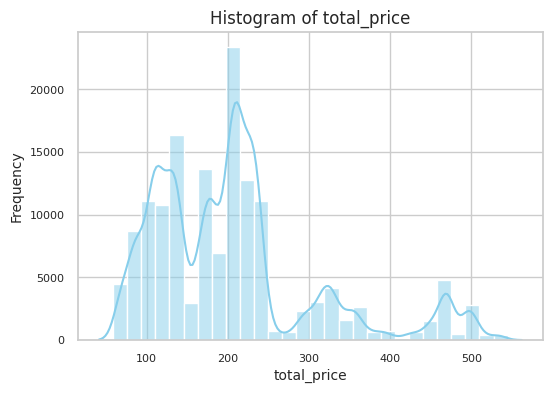

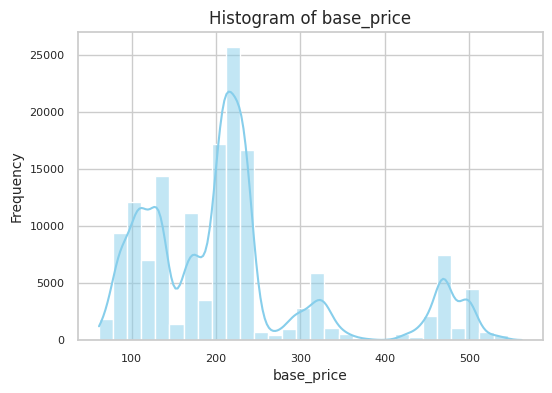

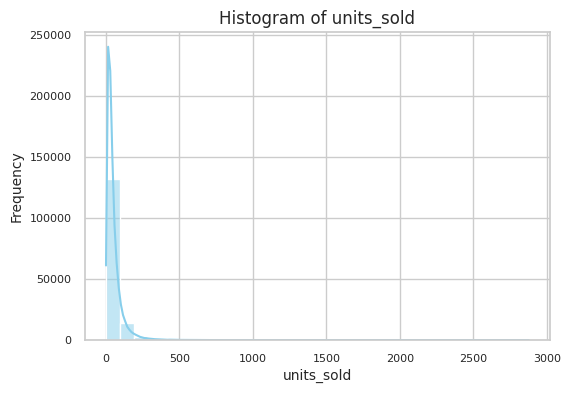



===== Boxplots for Numerical Features =====


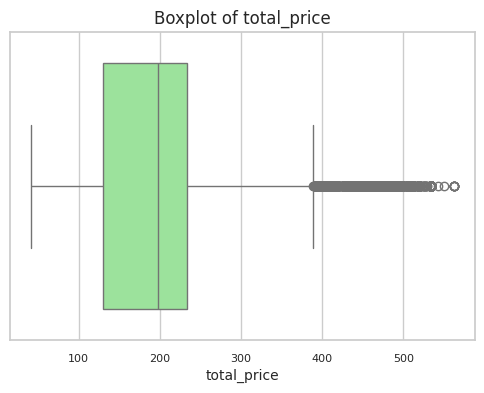

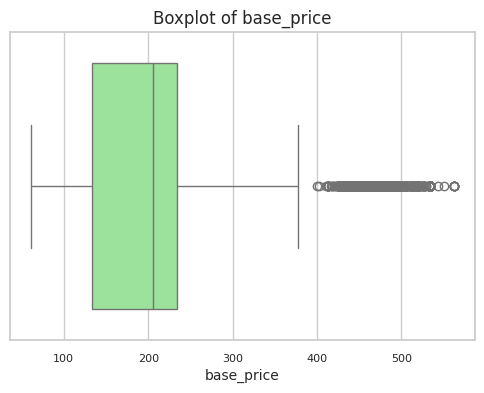

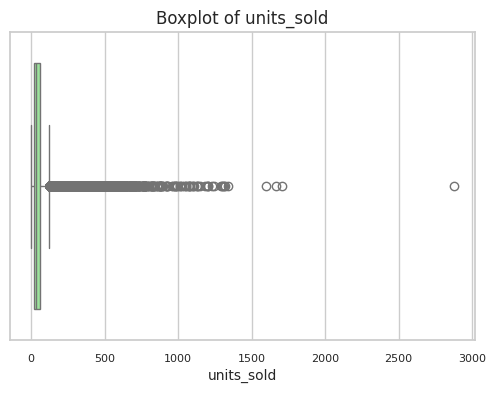



===== Correlation Heatmap (Numerical Features) =====


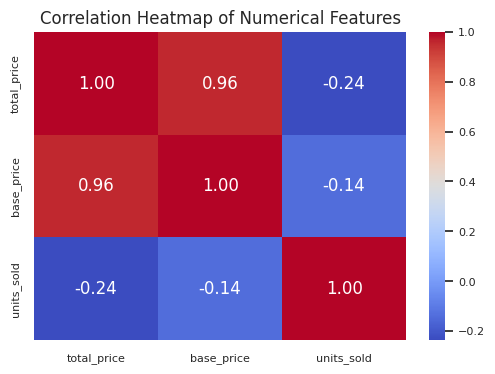



===== Unique Values for Categorical and Time-based Variables =====
'record_ID': 150150 unique values
'store_id': 76 unique values
'sku_id': 28 unique values
'is_featured_sku': 2 unique values
'is_display_sku': 2 unique values
'day': 31 unique values
'month': 12 unique values
'year': 3 unique values
'week_of_year': 52 unique values
'day_of_week': 2 unique values
'is_start_of_year': 2 unique values
'is_end_of_year': 2 unique values
'week_of_month': 6 unique values


===== Boxplot of 'units_sold' by Time-based Features =====


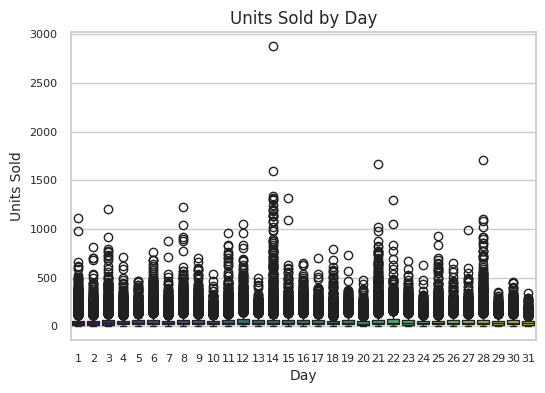

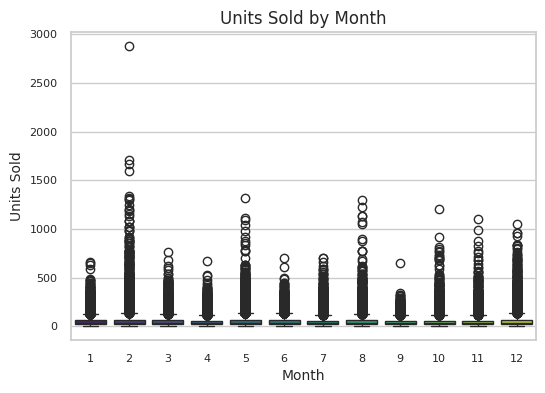

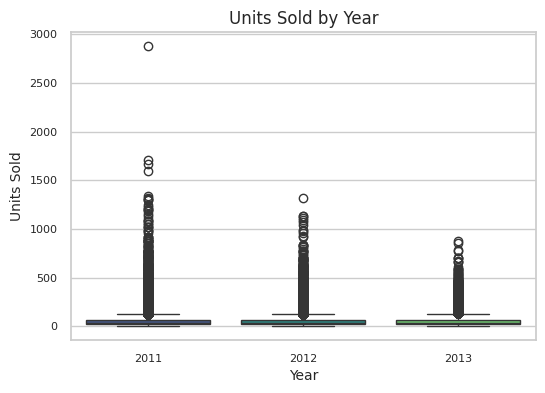



===== Bar Plot of Total Units Sold per Month =====


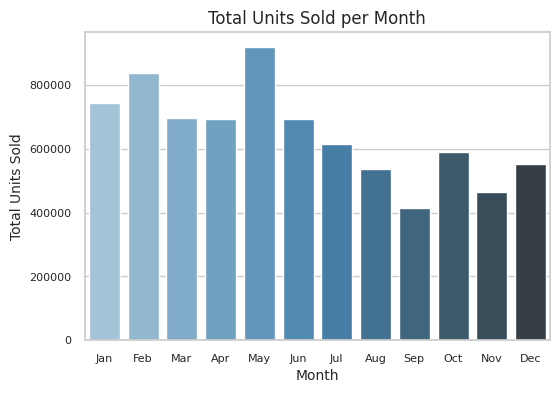



===== Bar Plot of Total Units Sold per Year =====


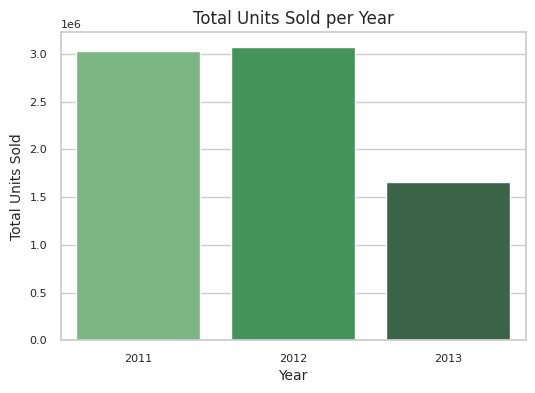



===== Bar Plot of Total Units Sold by Item (sku_id) for Each Year =====


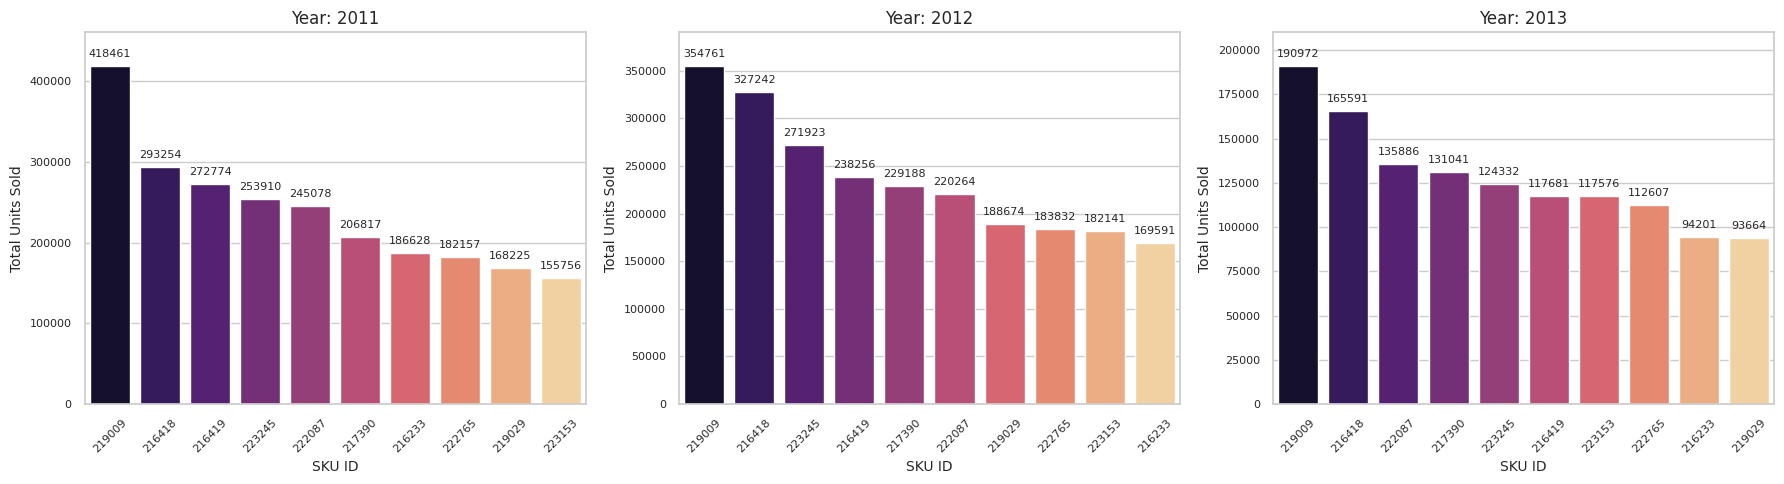



===== Data Exploration Completed =====


In [10]:
# Perform comprehensive EDA
explore_data(df)

In [11]:
def count_unique_dates(df):
    """
    Counts the number of unique dates associated with each store_id and each sku_id.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data with 'store_id', 'sku_id', and 'date' columns.

    Returns:
    - store_unique_dates (pd.DataFrame): DataFrame with 'store_id' and 'unique_dates_count'.
    - sku_unique_dates (pd.DataFrame): DataFrame with 'sku_id' and 'unique_dates_count'.
    """
    # Required columns
    required_cols = ['store_id', 'sku_id', 'date']

    # Check if all required columns are present
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing from the DataFrame: {missing_cols}")

    # Ensure 'date' column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if df['date'].isnull().any():
            raise ValueError("Some dates could not be converted to datetime. Please check the 'date' column.")

    # Number of unique dates per store_id
    store_unique_dates = (
        df.groupby('store_id')['date']
        .nunique()
        .reset_index()
        .rename(columns={'date': 'unique_dates_count'})
        .sort_values(by='unique_dates_count', ascending=False)
    )

    # Number of unique dates per sku_id
    sku_unique_dates = (
        df.groupby('sku_id')['date']
        .nunique()
        .reset_index()
        .rename(columns={'date': 'unique_dates_count'})
        .sort_values(by='unique_dates_count', ascending=False)
    )

    return store_unique_dates, sku_unique_dates

In [12]:
# Check unique dates per 'store_id' and 'sku_id'
store_unique_dates_df, sku_unique_dates_df = count_unique_dates(df)

# Display the number of unique dates per store_id
print("Unique Dates per Store ID:")
display(store_unique_dates_df)

# Display the number of unique dates per sku_id
print("\nUnique Dates per SKU ID:")
display(sku_unique_dates_df)

Unique Dates per Store ID:


,store_id,unique_dates_count
0,8023,130
48,9532,130
55,9700,130
54,9680,130
53,9672,130
52,9632,130
51,9613,130
50,9611,130
49,9578,130
47,9498,130



Unique Dates per SKU ID:


,sku_id,unique_dates_count
0,216233,130
1,216418,130
26,673209,130
25,600934,130
24,547934,130
23,546789,130
22,545621,130
21,398721,130
20,378934,130
19,327492,130


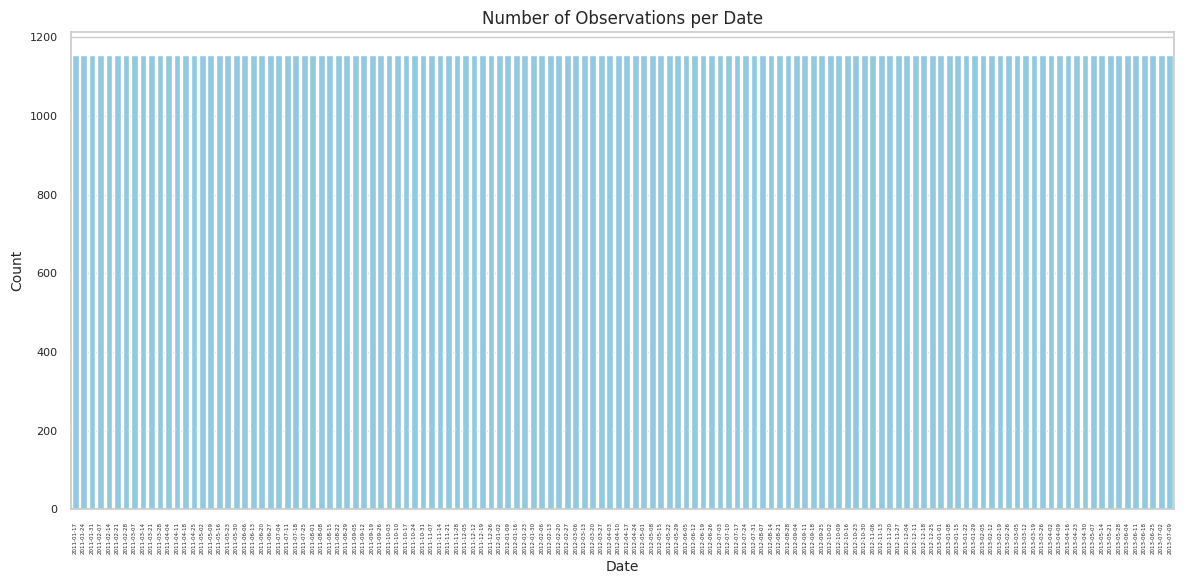

In [13]:
# Plot the number of observations per date
plt.figure(figsize=(12, 6))
sns.countplot(x='date', data=df, color='skyblue')
plt.xticks(rotation=90, fontsize=4)
plt.title('Number of Observations per Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [14]:
# Group analysis
unique_stores = df['store_id'].nunique()
unique_skus = df['sku_id'].nunique()
print(f"Unique Stores: {unique_stores}")
print(f"Unique SKUs: {unique_skus}")

Unique Stores: 76
Unique SKUs: 28


In [15]:
# Check the number of records per store
store_counts = df['store_id'].value_counts()
print("Top 10 Stores by Number of Records:")
display(store_counts.head(10))

# Check the number of records per SKU
sku_counts = df['sku_id'].value_counts()
print("\nTop 10 SKUs by Number of Records:")
display(sku_counts.head(10))

Top 10 Stores by Number of Records:


,count
store_id,
8094,3120
8991,2990
9823,2990
8023,2730
8438,2730
9279,2600
8317,2600
9872,2600
9273,2470



Top 10 SKUs by Number of Records:


,count
sku_id,
219009,9750
216233,9620
223245,9490
219029,9490
222087,9360
217390,9100
222765,8970
216418,8840
216419,8710


In [16]:
# Active periods of each store
print("Analyzing active periods of each store:")
store_active_period = df.groupby('store_id')['date'].agg(['min', 'max'])
display(store_active_period.head())

# Active periods of each SKU
print("\nAnalyzing active periods of each SKU:")
sku_active_period = df.groupby('sku_id')['date'].agg(['min', 'max'])
display(sku_active_period.head())

Analyzing active periods of each store:


,min,max
store_id,,
8023,2011-01-17,2013-07-09
8058,2011-01-17,2013-07-09
8063,2011-01-17,2013-07-09
8091,2011-01-17,2013-07-09
8094,2011-01-17,2013-07-09



Analyzing active periods of each SKU:


,min,max
sku_id,,
216233,2011-01-17,2013-07-09
216418,2011-01-17,2013-07-09
216419,2011-01-17,2013-07-09
216425,2011-01-17,2013-07-09
217217,2011-01-17,2013-07-09


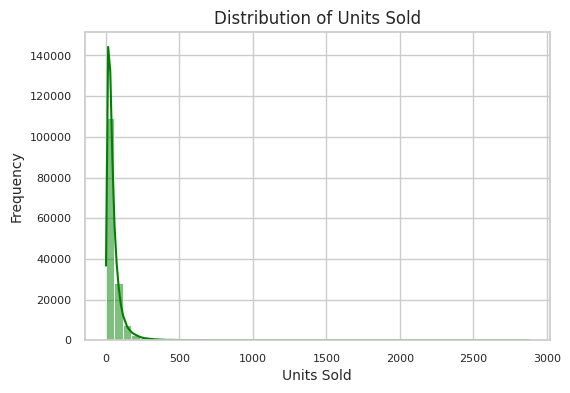

In [17]:
# Distribution of units_sold
plt.figure(figsize=(6, 4))
sns.histplot(df['units_sold'], bins=50, kde=True, color='green')
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

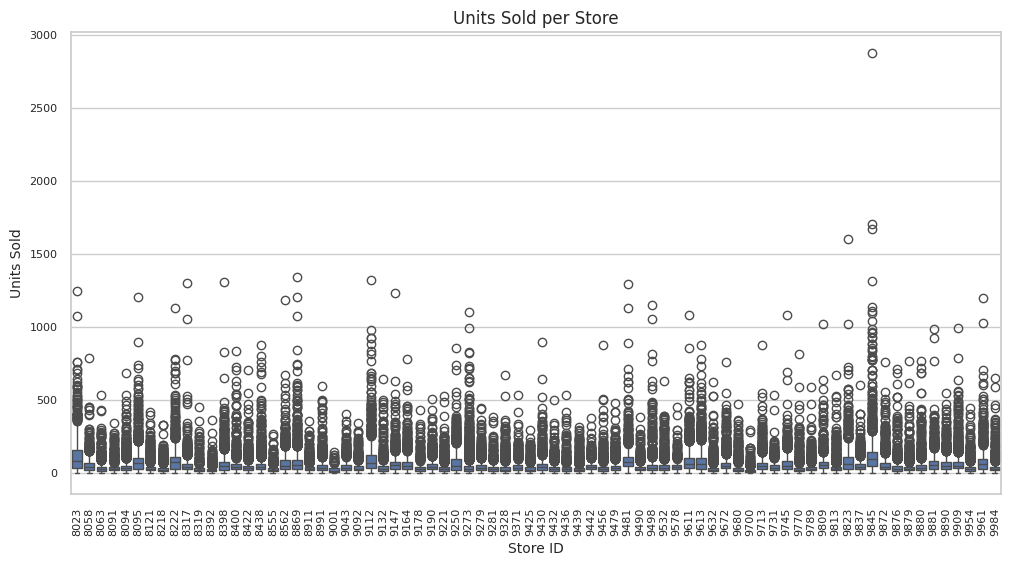

In [18]:
# Boxplot of units_sold per store
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_id', y='units_sold', data=df)
plt.title('Units Sold per Store')
plt.xlabel('Store ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

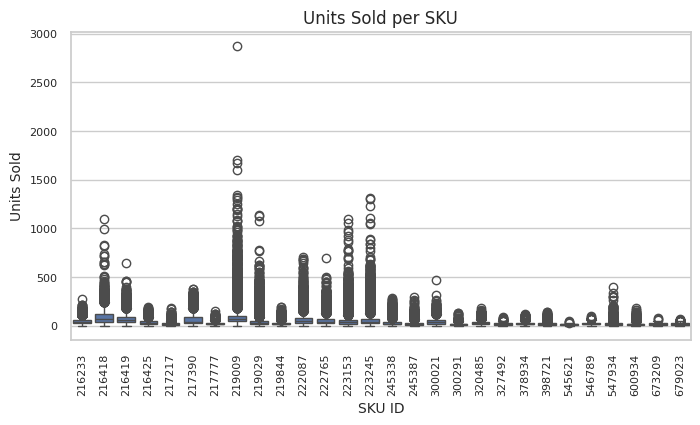

In [19]:
# Boxplot of units_sold per SKU
plt.figure(figsize=(8, 4))
sns.boxplot(x='sku_id', y='units_sold', data=df)
plt.title('Units Sold per SKU')
plt.xlabel('SKU ID')
plt.ylabel('Units Sold')
plt.xticks(rotation=90)
plt.show()

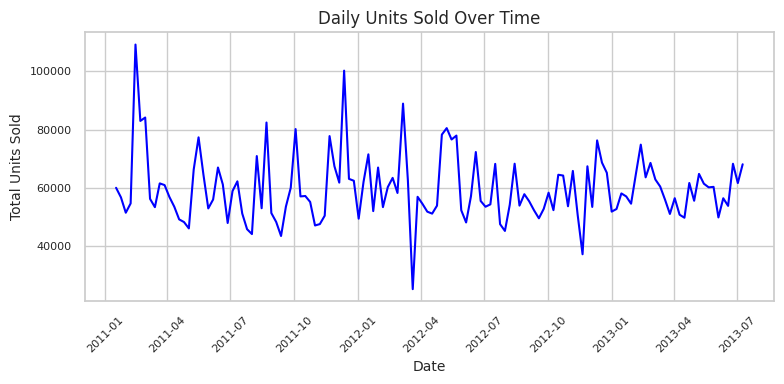

In [20]:
# Time series plot for overall units sold
plt.figure(figsize=(8, 4))
df_sorted = df.sort_values('date')
units_sold_daily = df_sorted.groupby('date')['units_sold'].sum()
plt.plot(units_sold_daily.index, units_sold_daily.values, color='blue')
plt.title('Daily Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

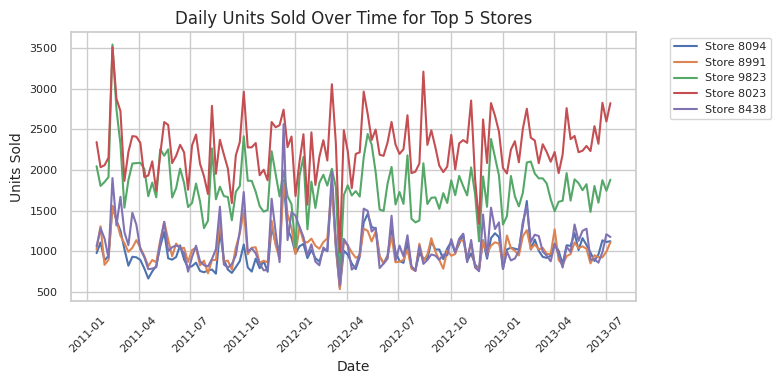

In [21]:
# Units sold over time for top 5 stores
top5_stores = store_counts.head(5).index
plt.figure(figsize=(8, 4))
for store in top5_stores:
    store_data = df[df['store_id'] == store].groupby('date')['units_sold'].sum()
    plt.plot(store_data.index, store_data.values, label=f'Store {store}')
plt.title('Daily Units Sold Over Time for Top 5 Stores')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

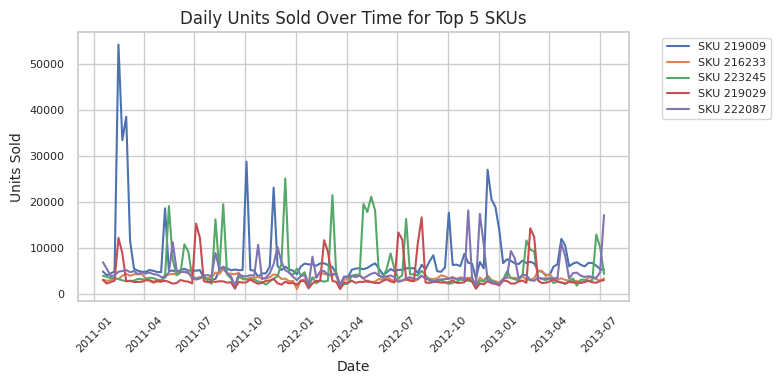

In [22]:
# Units sold over time for top 5 SKUs
top5_skus = sku_counts.head(5).index
plt.figure(figsize=(8, 4))
for sku in top5_skus:
    sku_data = df[df['sku_id'] == sku].groupby('date')['units_sold'].sum()
    plt.plot(sku_data.index, sku_data.values, label=f'SKU {sku}')
plt.title('Daily Units Sold Over Time for Top 5 SKUs')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

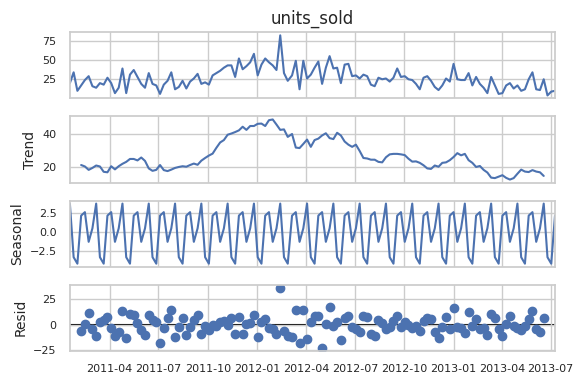

In [23]:
# Seasonal Decomposition
# Select a specific store and SKU for decomposition
example_store = df['store_id'].unique()[0]
example_sku = df['sku_id'].unique()[0]
example_df = df[(df['store_id'] == example_store) & (df['sku_id'] == example_sku)].sort_values('date')

# Aggregate units_sold by date
example_ts = example_df.groupby('date')['units_sold'].sum()

# Ensure there are enough data points for decomposition
if len(example_ts) >= 24:
    decomposition = seasonal_decompose(example_ts, model='additive', period=7)  # Weekly seasonality
    decomposition.plot()
    plt.show()
else:
    print("Not enough data points for seasonal decomposition.")

In [24]:
# Stationarity Test (Augmented Dickey-Fuller)
print("--- Stationarity Test (ADF) ---")
result = adfuller(units_sold_daily.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# Interpretation
if result[1] < 0.05:
    print("\nThe time series is stationary.")
else:
    print("\nThe time series is non-stationary.")

--- Stationarity Test (ADF) ---
ADF Statistic: -8.887476901170748
p-value: 1.2686851449322419e-14
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275

The time series is stationary.


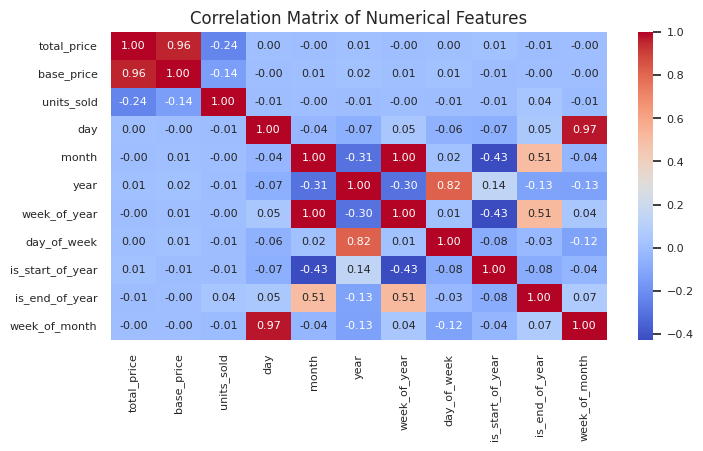

In [25]:
# Select numerical features for correlation
numeric_features = ['total_price', 'base_price', 'units_sold', 'day', 'month', 'year',
                    'week_of_year', 'day_of_week', 'is_start_of_year', 'is_end_of_year', 'week_of_month']

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"fontsize": 8}
)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Engineer Features

In [26]:
def feature_engineering(df, n_rows=5):
    """
    Perform feature engineering tailored for longitudinal panel data.

    Parameters:
    - df (pd.DataFrame): The DataFrame to engineer features on.
    - n_rows (int): Number of rows to display after feature engineering.

    Returns:
    - df (pd.DataFrame): DataFrame with new features.
    """
    # Ensure the data is sorted chronologically for each store and SKU
    df = df.sort_values(['store_id', 'sku_id', 'date'])

    # Create Lag Features: Previous 1, 2, and 3 weeks' units_sold
    df['units_sold_lag_1'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(1)
    df['units_sold_lag_2'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(2)
    df['units_sold_lag_3'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(3)

    # Create Rolling Features: 4-week rolling mean and std
    df['units_sold_roll_mean_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
    df['units_sold_roll_std_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

    # Exponential Moving Average (span=4)
    df['units_sold_ema_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.ewm(span=4, adjust=False).mean())

    # Create Differenced Features for Stationarity
    df['units_sold_diff_1'] = df.groupby(['store_id', 'sku_id'])['units_sold'].diff(1)
    df['units_sold_diff_2'] = df.groupby(['store_id', 'sku_id'])['units_sold'].diff(2)

    # Drop rows with NaN values resulting from lagged and differenced features
    df = df.dropna(subset=['units_sold_lag_1', 'units_sold_lag_2', 'units_sold_lag_3',
                           'units_sold_roll_mean_4', 'units_sold_roll_std_4', 'units_sold_ema_4',
                           'units_sold_diff_1', 'units_sold_diff_2'])

    # Reset index after dropping rows
    df = df.reset_index(drop=True)

    # Create Interaction Features
    df['price_per_unit'] = df['total_price'] / df['units_sold']

    # Cyclical Encoding for Month and Week of Year
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['week_sin'] = np.sin(2 * np.pi * df['week_of_year']/52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_of_year']/52)

    print("===== Feature Engineering Completed =====")
    print(f"Data shape after feature engineering: {df.shape}")

    display(df.head(n_rows))
    print("\n")
    display(df.tail(n_rows))

    return df

In [27]:
# Apply feature engineering
df = feature_engineering(df, n_rows=20)

===== Feature Engineering Completed =====
Data shape after feature engineering: (146685, 30)


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,units_sold_diff_1,units_sold_diff_2,price_per_unit,month_sin,month_cos,week_sin,week_cos
0,5011,8023,216233,133.9500,133.9500,0,0,115,2011-02-07,7,2,2011,6,0,0,0,2,135.0,87.0,114.0,112.75,19.704060,115.552000,-20.0,28.0,1.164783,8.660254e-01,5.000000e-01,0.663123,7.485107e-01
1,6651,8023,216233,133.2375,133.2375,0,0,93,2011-02-14,14,2,2011,7,0,0,0,3,115.0,135.0,87.0,107.50,21.931712,106.531200,-22.0,-42.0,1.432661,8.660254e-01,5.000000e-01,0.748511,6.631227e-01
2,8289,8023,216233,115.4250,133.2375,0,0,150,2011-02-21,21,2,2011,8,0,0,0,4,93.0,115.0,135.0,123.25,24.743686,123.918720,57.0,35.0,0.769500,8.660254e-01,5.000000e-01,0.822984,5.680647e-01
3,9923,8023,216233,115.4250,133.2375,0,0,134,2011-02-28,28,2,2011,9,0,0,0,5,150.0,93.0,115.0,123.00,24.589971,127.951232,-16.0,41.0,0.861381,8.660254e-01,5.000000e-01,0.885456,4.647232e-01
4,11537,8023,216233,117.5625,133.2375,0,0,130,2011-03-07,7,3,2011,10,0,0,0,2,134.0,150.0,93.0,126.75,24.102213,128.770739,-4.0,-20.0,0.904327,1.000000e+00,6.123234e-17,0.935016,3.546049e-01
5,13151,8023,216233,116.1375,133.2375,0,0,167,2011-03-14,14,3,2011,11,0,0,0,3,130.0,134.0,150.0,145.25,16.879475,144.062444,37.0,33.0,0.695434,1.000000e+00,6.123234e-17,0.970942,2.393157e-01
6,14789,8023,216233,118.2750,133.2375,0,0,126,2011-03-21,21,3,2011,12,0,0,0,4,167.0,130.0,134.0,139.25,18.786076,136.837466,-41.0,-4.0,0.938690,1.000000e+00,6.123234e-17,0.992709,1.205367e-01
7,16431,8023,216233,116.8500,133.2375,0,0,187,2011-03-28,28,3,2011,13,0,0,0,5,126.0,167.0,130.0,152.50,29.490111,156.902480,61.0,20.0,0.624866,1.000000e+00,6.123234e-17,1.000000,-1.608123e-16
8,18067,8023,216233,132.5250,132.5250,0,0,107,2011-04-04,4,4,2011,14,0,0,0,2,187.0,126.0,167.0,146.75,36.700363,136.941488,-80.0,-19.0,1.238551,8.660254e-01,-5.000000e-01,0.992709,-1.205367e-01
9,19703,8023,216233,133.9500,133.9500,0,0,85,2011-04-11,11,4,2011,15,0,0,0,3,107.0,187.0,126.0,126.25,43.828263,116.164893,-22.0,-102.0,1.575882,8.660254e-01,-5.000000e-01,0.970942,-2.393157e-01


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,units_sold_diff_1,units_sold_diff_2,price_per_unit,month_sin,month_cos,week_sin,week_cos
146665,181518,9984,679023,177.4125,191.6625,0,1,16,2013-02-26,26,2,2013,9,1,0,0,5,20.0,35.0,24.0,23.75,8.180261,21.220813,-4.0,-19.0,11.088281,8.660254e-01,5.000000e-01,8.854560e-01,4.647232e-01
146666,183156,9984,679023,177.4125,177.4125,0,0,19,2013-03-05,5,3,2013,10,1,0,0,2,16.0,20.0,35.0,22.50,8.504901,20.332488,3.0,-1.0,9.337500,1.000000e+00,6.123234e-17,9.350162e-01,3.546049e-01
146667,184796,9984,679023,177.4125,177.4125,0,0,13,2013-03-12,12,3,2013,11,1,0,0,3,19.0,16.0,20.0,17.00,3.162278,17.399493,-6.0,-3.0,13.647115,1.000000e+00,6.123234e-17,9.709418e-01,2.393157e-01
146668,186439,9984,679023,177.4125,177.4125,0,0,24,2013-03-19,19,3,2013,12,1,0,0,4,13.0,19.0,16.0,18.00,4.690416,20.039696,11.0,5.0,7.392187,1.000000e+00,6.123234e-17,9.927089e-01,1.205367e-01
146669,188078,9984,679023,213.0375,213.0375,0,0,5,2013-03-26,26,3,2013,13,1,0,0,5,24.0,13.0,19.0,15.25,8.180261,14.023817,-19.0,-8.0,42.607500,1.000000e+00,6.123234e-17,1.000000e+00,-1.608123e-16
146670,189717,9984,679023,213.0375,213.0375,0,0,13,2013-04-02,2,4,2013,14,1,0,0,1,5.0,24.0,13.0,13.75,7.804913,13.614290,8.0,-11.0,16.387500,8.660254e-01,-5.000000e-01,9.927089e-01,-1.205367e-01
146671,191354,9984,679023,213.0375,213.0375,0,0,9,2013-04-09,9,4,2013,15,1,0,0,2,13.0,5.0,24.0,12.75,8.180261,11.768574,-4.0,4.0,23.670833,8.660254e-01,-5.000000e-01,9.709418e-01,-2.393157e-01
146672,192990,9984,679023,213.0375,213.0375,0,0,17,2013-04-16,16,4,2013,16,1,0,0,3,9.0,13.0,5.0,11.00,5.163978,13.861145,8.0,4.0,12.531618,8.660254e-01,-5.000000e-01,9.350162e-01,-3.546049e-01
146673,194623,9984,679023,213.0375,213.0375,0,0,18,2013-04-23,23,4,2013,17,1,0,0,4,17.0,9.0,13.0,14.25,4.112988,15.516687,1.0,9.0,11.835417,8.660254e-01,-5.000000e-01,8.854560e-01,-4.647232e-01
146674,196257,9984,679023,213.0375,213.0375,0,0,19,2013-04-30,30,4,2013,18,1,0,0,5,18.0,17.0,9.0,15.75,4.573474,16.910012,1.0,2.0,11.212500,8.660254e-01,-5.000000e-01,8.229839e-01,-5.680647e-01


In [28]:
def interactive_correlation_heatmap(df):
    """
    Create an interactive correlation heatmap using Plotly.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.

    Returns:
    - None
    """
    # Select numerical features including the target variable and engineered features
    numerical_cols = ['total_price', 'base_price', 'units_sold', 'units_sold_lag_1',
                      'units_sold_lag_2', 'units_sold_lag_3', 'units_sold_roll_mean_4',
                      'units_sold_roll_std_4', 'units_sold_ema_4', 'price_per_unit',
                      'month_sin', 'month_cos', 'week_sin', 'week_cos',
                      'units_sold_diff_1', 'units_sold_diff_2']

    corr = df[numerical_cols].corr()
    fig = px.imshow(corr,
                    text_auto=True,
                    aspect="auto",
                    color_continuous_scale='RdBu_r',
                    title='Interactive Correlation Heatmap')
    fig.show()

In [29]:
# # Interactive Correlation Heatmap
# interactive_correlation_heatmap(df)

In [30]:
def interactive_scatter_plot(df, x_col, y_col, color_col=None):
    """
    Create an interactive scatter plot using Plotly.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - color_col (str): Column name for color encoding.

    Returns:
    - None
    """
    fig = px.scatter(df, x=x_col, y=y_col, color=color_col,
                     title=f'Interactive Scatter Plot: {y_col} vs. {x_col}',
                     hover_data=df.columns)
    fig.show()

In [31]:
# # Interactive Scatter Plot for Price per Unit vs. Units Sold
# if 'price_per_unit' in df.columns:
#     interactive_scatter_plot(df, 'price_per_unit', 'units_sold')
# else:
#     print("Column 'price_per_unit' not found.")

In [32]:
def interactive_time_series_plot(df, group_cols, time_col, target_col):
    """
    Create an interactive time series plot using Plotly for multiple entities.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.
    - group_cols (list): Columns to group by (e.g., ['store_id', 'sku_id']).
    - time_col (str): Column name for the time axis.
    - target_col (str): Column name for the target variable.

    Returns:
    - None
    """
    # Aggregate data if necessary
    fig = px.line(df, x=time_col, y=target_col, color=group_cols[0],
                  line_group=group_cols[1],
                  title=f'Interactive Time Series Plot: {target_col} Over Time by {group_cols}',
                  hover_data=df.columns)
    fig.show()

In [33]:
# # Interactive Time Series Plot for Units Sold over Time by Store and SKU
# if 'date' in df.columns and 'store_id' in df.columns and 'sku_id' in df.columns:
#     # Sort the DataFrame by date
#     sorted_df = df.sort_values('date')
#     interactive_time_series_plot(sorted_df, ['store_id', 'sku_id'], 'date', 'units_sold')
# else:
#     print("Necessary columns for time series plot not found.")

# Preprocess the Data

In [34]:
def preprocess_data(df):
    """
    Preprocess the DataFrame by handling categorical variables using Target Encoding and scaling numerical features.

    Parameters:
    - df (pd.DataFrame): The DataFrame to preprocess.

    Returns:
    - X (pd.DataFrame): Features after preprocessing.
    - y (pd.Series): Target variable.
    - preprocessor (ColumnTransformer): The preprocessing pipeline.
    - feature_names (list): List of feature names after preprocessing.
    - dates (pd.Series): The 'date' column.
    """
    # Define target variable
    y = df['units_sold']

    # Retain 'date' separately
    dates = df['date']

    # Identify numerical and categorical columns
    numerical_cols = ['total_price', 'base_price', 'units_sold_lag_1', 'units_sold_lag_2',
                      'units_sold_lag_3', 'units_sold_roll_mean_4', 'units_sold_roll_std_4',
                      'units_sold_ema_4', 'price_per_unit', 'month_sin', 'month_cos',
                      'week_sin', 'week_cos',
                      'units_sold_diff_1', 'units_sold_diff_2']
    categorical_cols = ['store_id', 'sku_id',
                        'is_featured_sku', 'is_display_sku',
                        'is_start_of_year', 'is_end_of_year']

    # Select only the specified columns
    X = df[numerical_cols + categorical_cols]

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data using Target Encoding
    categorical_transformer = Pipeline(steps=[
        ('target_encoder', TargetEncoder())
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        remainder='drop'
    )

    print("===== Data Preprocessing Setup Completed =====")
    print(f"Numerical Columns: {numerical_cols}")
    print(f"Categorical Columns: {categorical_cols}")

    # Compile feature names after preprocessing
    # Since TargetEncoder outputs numerical columns, all features remain numerical after encoding
    feature_names = numerical_cols + categorical_cols

    return X, y, preprocessor, feature_names, dates

In [35]:
# Preprocess the data
X, y, preprocessor, feature_names, dates = preprocess_data(df)

===== Data Preprocessing Setup Completed =====
Numerical Columns: ['total_price', 'base_price', 'units_sold_lag_1', 'units_sold_lag_2', 'units_sold_lag_3', 'units_sold_roll_mean_4', 'units_sold_roll_std_4', 'units_sold_ema_4', 'price_per_unit', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'units_sold_diff_1', 'units_sold_diff_2']
Categorical Columns: ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'is_start_of_year', 'is_end_of_year']


In [36]:
# Inspect shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Inspect first few rows of preprocessed features
print("\nFirst 5 rows of preprocessed features:")
display(pd.DataFrame(X[:5], columns=feature_names))

# Inspect first few rows of the target
print("\nFirst 5 rows of the target:")
display(y[:5])

Shape of X: (146685, 21)
Shape of y: (146685,)

First 5 rows of preprocessed features:


,total_price,base_price,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,price_per_unit,month_sin,month_cos,week_sin,week_cos,units_sold_diff_1,units_sold_diff_2,store_id,sku_id,is_featured_sku,is_display_sku,is_start_of_year,is_end_of_year
0,133.9500,133.9500,135.0,87.0,114.0,112.75,19.704060,115.552000,1.164783,0.866025,5.000000e-01,0.663123,0.748511,-20.0,28.0,8023,216233,0,0,0,0
1,133.2375,133.2375,115.0,135.0,87.0,107.50,21.931712,106.531200,1.432661,0.866025,5.000000e-01,0.748511,0.663123,-22.0,-42.0,8023,216233,0,0,0,0
2,115.4250,133.2375,93.0,115.0,135.0,123.25,24.743686,123.918720,0.769500,0.866025,5.000000e-01,0.822984,0.568065,57.0,35.0,8023,216233,0,0,0,0
3,115.4250,133.2375,150.0,93.0,115.0,123.00,24.589971,127.951232,0.861381,0.866025,5.000000e-01,0.885456,0.464723,-16.0,41.0,8023,216233,0,0,0,0
4,117.5625,133.2375,134.0,150.0,93.0,126.75,24.102213,128.770739,0.904327,1.000000,6.123234e-17,0.935016,0.354605,-4.0,-20.0,8023,216233,0,0,0,0



First 5 rows of the target:


,units_sold
0,115
1,93
2,150
3,134
4,130


In [37]:
def split_data(
    X,
    y,
    dates,
    date_col='date',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    sort_col='date',
    group_cols=['store_id', 'sku_id'],
    ensure_group_in_train=True,
    verbose=True
):
    """
    Splits the feature and target datasets into training, validation, and testing sets based on temporal order.

    Parameters:
    -----------
    X : pd.DataFrame
        The input DataFrame containing feature data with longitudinal panel structure.
    y : pd.Series or pd.DataFrame
        The target variable(s) corresponding to the feature DataFrame.
    dates : pd.Series
        The date information corresponding to each record in X.
    date_col : str, default 'date'
        The name of the column representing dates.
    train_ratio : float, default 0.7
        The proportion of data to include in the training set.
    val_ratio : float, default 0.15
        The proportion of data to include in the validation set.
    test_ratio : float, default 0.15
        The proportion of data to include in the testing set.
    sort_col : str, default 'date'
        The column name to sort the DataFrame by before splitting.
    group_cols : list, default ['store_id', 'sku_id']
        The list of columns representing groups in the dataset.
    ensure_group_in_train : bool, default True
        If True, ensures that all groups in validation and testing sets are present in the training set.
    verbose : bool, default True
        If True, prints detailed information during the splitting process.

    Returns:
    --------
    X_train : pd.DataFrame
        The training set features.
    X_validation : pd.DataFrame
        The validation set features.
    X_test : pd.DataFrame
        The testing set features.
    y_train : pd.Series or pd.DataFrame
        The training set targets.
    y_validation : pd.Series or pd.DataFrame
        The validation set targets.
    y_test : pd.Series or pd.DataFrame
        The testing set targets.
    """

    # 1. Validate split ratios
    total = train_ratio + val_ratio + test_ratio
    if not abs(total - 1.0) < 1e-6:
        raise ValueError(f"Train, validation, and test ratios must sum to 1. Current sum is {total}.")

    # 2. Combine X, y, and dates for consistent splitting
    df = X.copy()
    df['__target__'] = y.values
    df['__date__'] = dates.values
    if verbose:
        print("Combined feature, target, and date data for splitting.")

    # 3. Sort the DataFrame by the specified sort column (date)
    df_sorted = df.sort_values(by=sort_col).reset_index(drop=True)
    if verbose:
        print(f"DataFrame sorted by '{sort_col}'.")

    # 4. Extract unique sorted dates
    unique_dates = df_sorted['__date__'].drop_duplicates().sort_values()
    total_dates = unique_dates.nunique()

    if verbose:
        print(f"Total unique dates: {total_dates}")

    # 5. Calculate number of dates for each split
    train_end = int(train_ratio * total_dates)
    val_end = train_end + int(val_ratio * total_dates)

    train_dates = unique_dates.iloc[:train_end]
    validation_dates = unique_dates.iloc[train_end:val_end]
    test_dates = unique_dates.iloc[val_end:]

    if verbose:
        print(f"\nTraining set dates: {train_dates.min()} to {train_dates.max()} ({len(train_dates)} dates)")
        print(f"Validation set dates: {validation_dates.min()} to {validation_dates.max()} ({len(validation_dates)} dates)")
        print(f"Testing set dates: {test_dates.min()} to {test_dates.max()} ({len(test_dates)} dates)")

    # 6. Split the DataFrame
    train_df = df_sorted[df_sorted['__date__'].isin(train_dates)].reset_index(drop=True)
    validation_df = df_sorted[df_sorted['__date__'].isin(validation_dates)].reset_index(drop=True)
    test_df = df_sorted[df_sorted['__date__'].isin(test_dates)].reset_index(drop=True)

    if verbose:
        print(f"\nTraining set: {train_df.shape[0]} records")
        print(f"Validation set: {validation_df.shape[0]} records")
        print(f"Testing set: {test_df.shape[0]} records")

    # 7. Calculate and print actual split ratios
    total_records = train_df.shape[0] + validation_df.shape[0] + test_df.shape[0]
    train_pct = (train_df.shape[0] / total_records) * 100
    val_pct = (validation_df.shape[0] / total_records) * 100
    test_pct = (test_df.shape[0] / total_records) * 100

    if verbose:
        print(f"\nActual Split Ratios:")
        print(f"Training Set: {train_pct:.2f}%")
        print(f"Validation Set: {val_pct:.2f}%")
        print(f"Testing Set: {test_pct:.2f}%\n")

    # 8. Ensure no overlap between splits
    overlap_train_val = set(train_df['__date__']).intersection(set(validation_df['__date__']))
    overlap_train_test = set(train_df['__date__']).intersection(set(test_df['__date__']))
    overlap_val_test = set(validation_df['__date__']).intersection(set(test_df['__date__']))

    assert not overlap_train_val, "There is an overlap between training and validation sets."
    assert not overlap_train_test, "There is an overlap between training and testing sets."
    assert not overlap_val_test, "There is an overlap between validation and testing sets."

    if verbose:
        print("No overlapping dates between training, validation, and testing sets.")

    # 9. Ensure group consistency
    if ensure_group_in_train:
        # Identify unique groups in training set
        train_groups = train_df[group_cols].drop_duplicates()

        # Merge validation and testing sets with training groups
        validation_merged = validation_df.merge(train_groups, on=group_cols, how='left', indicator=True)
        test_merged = test_df.merge(train_groups, on=group_cols, how='left', indicator=True)

        # Find groups in validation not in training
        val_new_groups = validation_merged[validation_merged['_merge'] == 'left_only']
        test_new_groups = test_merged[test_merged['_merge'] == 'left_only']

        num_val_new_groups = val_new_groups[group_cols].drop_duplicates().shape[0]
        num_test_new_groups = test_new_groups[group_cols].drop_duplicates().shape[0]

        if num_val_new_groups > 0 or num_test_new_groups > 0:
            if verbose:
                print(f"Number of new groups in validation set not present in training set: {num_val_new_groups}")
                print(f"Number of new groups in testing set not present in training set: {num_test_new_groups}")
            raise ValueError("Validation or Testing sets contain groups not present in the Training set. "
                             "Consider adjusting the split ratios or ensuring group consistency.")
        else:
            if verbose:
                print(f"All groups in validation and testing sets are present in the training set.\n")

    # 10. Split back into X and y
    X_train = train_df.drop(columns=['__target__', '__date__']).reset_index(drop=True)
    X_validation = validation_df.drop(columns=['__target__', '__date__']).reset_index(drop=True)
    X_test = test_df.drop(columns=['__target__', '__date__']).reset_index(drop=True)

    y_train = train_df['__target__'].reset_index(drop=True)
    y_validation = validation_df['__target__'].reset_index(drop=True)
    y_test = test_df['__target__'].reset_index(drop=True)

    # 11. Visualize the split
    if verbose:
        # Define the desired order of splits
        split_order = ['Training', 'Validation', 'Testing']

        # Define a color palette matching the split order
        # Blue for Training, orange for Validation, green for Testing
        custom_palette = ['blue', 'orange', 'green']

        # Aggregate the number of records per store_id in each split
        train_counts = X_train['store_id'].value_counts().reset_index()
        train_counts.columns = ['store_id', 'count']
        train_counts['split'] = 'Training'

        validation_counts = X_validation['store_id'].value_counts().reset_index()
        validation_counts.columns = ['store_id', 'count']
        validation_counts['split'] = 'Validation'

        test_counts = X_test['store_id'].value_counts().reset_index()
        test_counts.columns = ['store_id', 'count']
        test_counts['split'] = 'Testing'

        # Combine all counts into a single DataFrame
        combined_counts = pd.concat([train_counts, validation_counts, test_counts], ignore_index=True)

        # Handle store_ids that may not be present in all splits
        combined_counts = combined_counts.groupby(['store_id', 'split']).sum().reset_index()

        # Plotting using Boxplot and Swarmplot with specified order
        plt.figure(figsize=(6, 4))

        # Boxplot with specified order and custom palette
        sns.boxplot(
            x='split',
            y='count',
            data=combined_counts,
            order=split_order,
            palette=custom_palette
        )

        # Swarmplot with the same order
        sns.swarmplot(
            x='split',
            y='count',
            data=combined_counts,
            order=split_order,
            color='black',
            alpha=0.3
        )

        plt.title('Distribution of Record Counts per Store ID Across Splits')
        plt.xlabel('Data Split')
        plt.ylabel('Number of Records per Store ID')
        plt.tight_layout()
        plt.show()

        # KDE plot
        plt.figure(figsize=(6, 4))
        sns.histplot(train_counts['count'], color='blue', label='Training', kde=True, stat='density', alpha=0.5)
        sns.histplot(validation_counts['count'], color='orange', label='Validation', kde=True, stat='density', alpha=0.5)
        sns.histplot(test_counts['count'], color='green', label='Testing', kde=True, stat='density', alpha=0.5)
        plt.legend()
        plt.title('Distribution of Record Counts per Store ID Across Splits')
        plt.xlabel('Number of Records per Store ID')
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()

    # 12. Display summary statistics
    summary_stats = combined_counts.groupby('split')['count'].describe().reindex(split_order)
    print("\nSummary Statistics of Record Counts per Store ID:")
    display(summary_stats)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

Combined feature, target, and date data for splitting.
DataFrame sorted by '__date__'.
Total unique dates: 127

Training set dates: 2011-02-07 00:00:00 to 2012-10-09 00:00:00 (88 dates)
Validation set dates: 2012-10-16 00:00:00 to 2013-02-19 00:00:00 (19 dates)
Testing set dates: 2013-02-26 00:00:00 to 2013-07-09 00:00:00 (20 dates)

Training set: 101640 records
Validation set: 21945 records
Testing set: 23100 records

Actual Split Ratios:
Training Set: 69.29%
Validation Set: 14.96%
Testing Set: 15.75%

No overlapping dates between training, validation, and testing sets.
All groups in validation and testing sets are present in the training set.



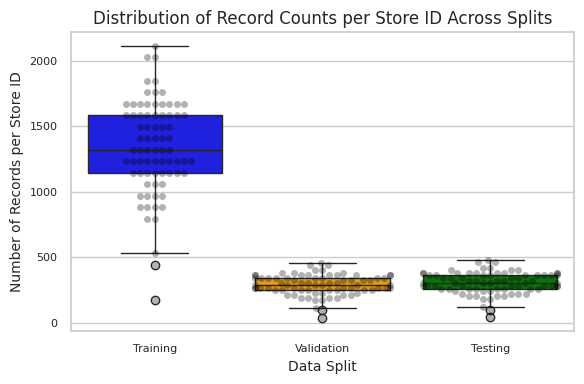

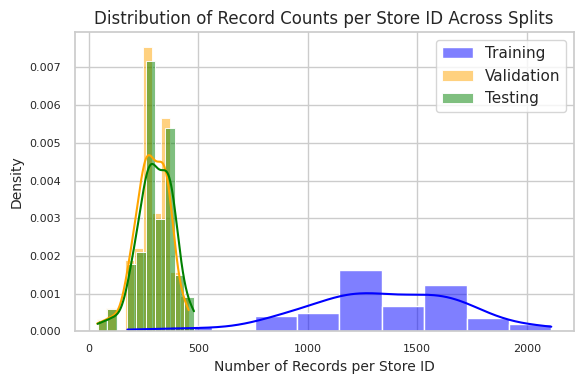


Summary Statistics of Record Counts per Store ID:


,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
Training,76.0,1337.368421,360.411944,176.0,1144.0,1320.0,1584.0,2112.0
Validation,76.0,288.750000,77.816215,38.0,247.0,285.0,342.0,456.0
Testing,76.0,303.947368,81.911805,40.0,260.0,300.0,360.0,480.0


In [38]:
# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X=X,
    y=y,
    dates=dates,
    date_col='__date__',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    sort_col='__date__',
    group_cols=['store_id', 'sku_id'],
    ensure_group_in_train=True,
    verbose=True
)

In [39]:
# Display the first few rows of each split
print("Training Set Features:")
display(X_train.head())

print("\nTraining Set Target:")
display(y_train.head())

print("\nValidation Set Features:")
display(X_val.head())

print("\nValidation Set Target:")
display(y_val.head())

print("\nTesting Set Features:")
display(X_test.head())

print("\nTesting Set Target:")
display(y_test.head())

Training Set Features:


,total_price,base_price,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,price_per_unit,month_sin,month_cos,week_sin,week_cos,units_sold_diff_1,units_sold_diff_2,store_id,sku_id,is_featured_sku,is_display_sku,is_start_of_year,is_end_of_year
0,133.9500,133.9500,135.0,87.0,114.0,112.75,19.704060,115.552,1.164783,0.866025,0.5,0.663123,0.748511,-20.0,28.0,8023,216233,0,0,0,0
1,177.4125,177.4125,14.0,15.0,20.0,18.00,4.242641,19.040,7.713587,0.866025,0.5,0.663123,0.748511,9.0,8.0,9279,378934,0,0,0,0
2,448.1625,448.1625,21.0,31.0,30.0,27.00,4.546061,26.384,17.237019,0.866025,0.5,0.663123,0.748511,5.0,-5.0,9872,245338,0,0,0,0
3,227.2875,227.2875,124.0,101.0,332.0,174.75,106.167713,172.816,1.600616,0.866025,0.5,0.663123,0.748511,18.0,41.0,8222,222087,0,0,0,0
4,212.3250,212.3250,32.0,55.0,55.0,40.75,17.056279,35.880,10.110714,0.866025,0.5,0.663123,0.748511,-11.0,-34.0,8063,223153,0,0,0,0



Training Set Target:


,__target__
0,115
1,23
2,26
3,142
4,21



Validation Set Features:


,total_price,base_price,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,price_per_unit,month_sin,month_cos,week_sin,week_cos,units_sold_diff_1,units_sold_diff_2,store_id,sku_id,is_featured_sku,is_display_sku,is_start_of_year,is_end_of_year
0,104.7375,104.7375,89.0,65.0,74.0,71.00,14.071247,68.682197,1.870313,-0.866025,0.5,-0.935016,0.354605,-33.0,-9.0,9713,216419,0,0,0,0
1,295.6875,295.6875,25.0,21.0,32.0,26.00,4.546061,26.043558,11.372596,-0.866025,0.5,-0.935016,0.354605,1.0,5.0,8422,219029,0,0,0,0
2,138.2250,138.2250,71.0,43.0,62.0,63.50,15.154757,68.439003,1.772115,-0.866025,0.5,-0.935016,0.354605,7.0,35.0,8438,217390,0,0,0,0
3,327.0375,327.0375,81.0,45.0,54.0,53.25,20.402206,52.267637,9.910227,-0.866025,0.5,-0.935016,0.354605,-48.0,-12.0,9809,219029,0,0,0,0
4,88.3500,88.3500,93.0,82.0,106.0,94.50,9.949874,94.305763,0.910825,-0.866025,0.5,-0.935016,0.354605,4.0,15.0,8094,216419,0,0,0,0



Validation Set Target:


,__target__
0,56
1,26
2,78
3,33
4,97



Testing Set Features:


,total_price,base_price,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,price_per_unit,month_sin,month_cos,week_sin,week_cos,units_sold_diff_1,units_sold_diff_2,store_id,sku_id,is_featured_sku,is_display_sku,is_start_of_year,is_end_of_year
0,133.9500,133.9500,73.0,71.0,53.0,65.00,9.092121,66.091685,2.126190,0.866025,0.5,0.885456,0.464723,-10.0,-8.0,9961,216233,0,0,0,0
1,128.9625,128.9625,24.0,29.0,24.0,23.25,5.377422,21.688639,8.060156,0.866025,0.5,0.885456,0.464723,-8.0,-13.0,9132,216233,0,0,0,0
2,177.4125,177.4125,11.0,29.0,23.0,17.50,10.246951,13.538503,25.344643,0.866025,0.5,0.885456,0.464723,-4.0,-22.0,8095,547934,0,0,0,0
3,232.9875,208.7625,46.0,50.0,44.0,44.00,5.887841,40.425937,6.471875,0.866025,0.5,0.885456,0.464723,-10.0,-14.0,8094,217217,1,1,0,0
4,510.8625,510.8625,32.0,211.0,165.0,110.25,91.721953,70.249384,15.480682,0.866025,0.5,0.885456,0.464723,1.0,-178.0,8023,245338,0,0,0,0



Testing Set Target:


,__target__
0,63
1,16
2,7
3,36
4,33


In [40]:
# Summary statistics for the target sets
print("===== Training Set Statistics =====")
display(pd.Series(y_train).describe())

print("\n===== Validation Set Statistics =====")
display(pd.Series(y_val).describe())

print("\n===== Testing Set Statistics =====")
display(pd.Series(y_test).describe())

===== Training Set Statistics =====


,__target__
count,101640.000000
mean,51.829585
std,62.075571
min,1.000000
25%,20.000000
50%,35.000000
75%,62.000000
max,2876.000000



===== Validation Set Statistics =====


,__target__
count,21945.000000
mean,52.161267
std,59.259704
min,1.000000
25%,20.000000
50%,35.000000
75%,62.000000
max,991.000000



===== Testing Set Statistics =====


,__target__
count,23100.000000
mean,50.995498
std,54.816633
min,1.000000
25%,19.000000
50%,34.000000
75%,63.000000
max,880.000000


# Train the Models

In [41]:
def train_models_with_pipeline(X_train, y_train, preprocessor):
    """
    Train multiple regression models with preprocessing pipeline.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - preprocessor (ColumnTransformer): Preprocessing pipeline.

    Returns:
    - models (dict): Dictionary of trained models with pipelines.
    """
    models = {}

    # Random Forest Regressor Pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_pipeline.fit(X_train, y_train)
    models['RandomForest'] = rf_pipeline
    print("Trained Random Forest Regressor with pipeline.")

    # Histogram-Based Gradient Boosting Regressor Pipeline
    hgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ])
    hgb_pipeline.fit(X_train, y_train)
    models['HistGradientBoosting'] = hgb_pipeline
    print("Trained Histogram-Based Gradient Boosting Regressor with pipeline.")

    # XGBoost Regressor Pipeline
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, objective='reg:squarederror', device='gpu'))
    ])
    xgb_pipeline.fit(X_train, y_train)
    models['XGBoost'] = xgb_pipeline
    print("Trained XGBoost Regressor with pipeline.")

    # LightGBM Regressor Pipeline
    lgbm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', lightgbm.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1, device='gpu'))
    ])
    lgbm_pipeline.fit(X_train, y_train)
    models['LightGBM'] = lgbm_pipeline
    print("Trained LightGBM Regressor with pipeline.")

    # CatBoost Regressor Pipeline
    catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', catboost.CatBoostRegressor(
            iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42))
    ])
    catboost_pipeline.fit(X_train, y_train)
    models['CatBoost'] = catboost_pipeline
    print("Trained CatBoost Regressor with pipeline.")

    # # Stacking Regressor
    # estimators = [
    #     ('rf', models['RandomForest']),
    #     ('hgb', models['HistGradientBoosting']),
    #     ('xgb', models['XGBoost']),
    #     ('lgbm', models['LightGBM']),
    #     ('catboost', models['CatBoost'])
    # ]
    # stacking_reg = StackingRegressor(
    #     estimators=estimators,
    #     final_estimator=HistGradientBoostingRegressor(random_state=42),
    #     cv=5,
    #     passthrough=False,
    #     n_jobs=-1
    # )
    # stacking_reg.fit(X_train, y_train)
    # models['StackingRegressor'] = stacking_reg
    # print("Trained Stacking Regressor with pipeline.")

    return models

In [42]:
# Train models with pipelines
models = train_models_with_pipeline(X_train, y_train, preprocessor)

Trained Random Forest Regressor with pipeline.
Trained Histogram-Based Gradient Boosting Regressor with pipeline.
Trained XGBoost Regressor with pipeline.
Trained LightGBM Regressor with pipeline.
Trained CatBoost Regressor with pipeline.


In [43]:
# List trained models
print("===== Trained Models =====\n")
for model_name in models.keys():
    print(f"- {model_name}")

===== Trained Models =====

- RandomForest
- HistGradientBoosting
- XGBoost
- LightGBM
- CatBoost


In [44]:
def save_model(model, preprocessor, model_path='model.joblib', preprocessor_path='preprocessor.joblib'):
    """
    Save the trained model and preprocessor to disk.

    Parameters:
    - model: Trained machine learning model.
    - preprocessor: Fitted preprocessor.
    - model_path (str): File path to save the model.
    - preprocessor_path (str): File path to save the preprocessor.

    Returns:
    - None
    """
    joblib.dump(model, model_path)
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Model saved to {model_path}")
    print(f"Preprocessor saved to {preprocessor_path}\n")

In [45]:
# # Save models and preprocessor
# save_model(models['RandomForest'], preprocessor,
#            model_path='random_forest_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['HistGradientBoosting'], preprocessor,
#            model_path='histgradientboosting_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['XGBoost'], preprocessor,
#            model_path='xgboost_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['LightGBM'], preprocessor,
#            model_path='lightgbm_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['CatBoost'], preprocessor,
#            model_path='catboost_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['StackingRegressor'], preprocessor,
#            model_path='stacking_regressor_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# print("Models and preprocessor saved.")

# Evaluate the Models

In [46]:
def evaluate_models_cross_validated(models, X, y, cv_splits=5):
    """
    Evaluate trained models using cross-validation on the provided dataset.

    Parameters:
    - models (dict): Dictionary of trained models.
    - X (pd.DataFrame): Features for evaluation.
    - y (pd.Series): Target variable for evaluation.
    - cv_splits (int): Number of cross-validation splits.

    Returns:
    - evaluation_results (dict): Dictionary containing cross-validated evaluation metrics for each model.
    """
    evaluation_results = {}

    # Define custom scoring functions
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mae(y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)

    def mape(y_true, y_pred):
        return mean_absolute_percentage_error(y_true, y_pred)

    # Create a scoring dictionary
    scoring = {
        'RMSE': make_scorer(rmse, greater_is_better=False),
        'MAE': make_scorer(mae, greater_is_better=False),
        'MAPE': make_scorer(mape, greater_is_better=False),
        'R2': make_scorer(r2_score, greater_is_better=True),
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    for name, model in models.items():
        print(f"===== Evaluating {name} with Cross-Validation =====")

        # Perform cross-validation
        cv_rmse = cross_val_score(model, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        rmse_scores = -cv_rmse  # Since scores are negative

        cv_mae = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        mae_scores = -cv_mae

        cv_mape = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        mape_scores = -cv_mape

        cv_r2 = cross_val_score(model, X, y, cv=tscv, scoring='r2', n_jobs=-1)
        r2_scores = cv_r2

        # Store the mean and std of each metric
        metrics = {
            'Cross-Validated RMSE': rmse_scores.mean(),
            'Cross-Validated RMSE Std': rmse_scores.std(),
            'Cross-Validated MAE': mae_scores.mean(),
            'Cross-Validated MAE Std': mae_scores.std(),
            'Cross-Validated MAPE': mape_scores.mean(),
            'Cross-Validated MAPE Std': mape_scores.std(),
            'Cross-Validated R²': r2_scores.mean(),
            'Cross-Validated R² Std': r2_scores.std()
        }

        for metric, value in metrics.items():
            print(f"{metric}: {value:.2f}")

        # Store Metrics
        evaluation_results[name] = metrics

        # Visualization: Boxplots for each metric across folds
        print("\n")
        metrics_data = pd.DataFrame({
            'RMSE': rmse_scores,
            'MAE': mae_scores,
            'MAPE': mape_scores,
            'R²': r2_scores
        })

        plt.figure(figsize=(6, 4))
        sns.boxplot(data=metrics_data)
        plt.title(f'{name} - Cross-Validated Metrics Distribution')
        plt.ylabel('Metric Value')
        plt.show()
        print("\n")

    return evaluation_results

===== Evaluating RandomForest with Cross-Validation =====
Cross-Validated RMSE: 5.51
Cross-Validated RMSE Std: 2.10
Cross-Validated MAE: 1.09
Cross-Validated MAE Std: 0.29
Cross-Validated MAPE: 0.02
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.01




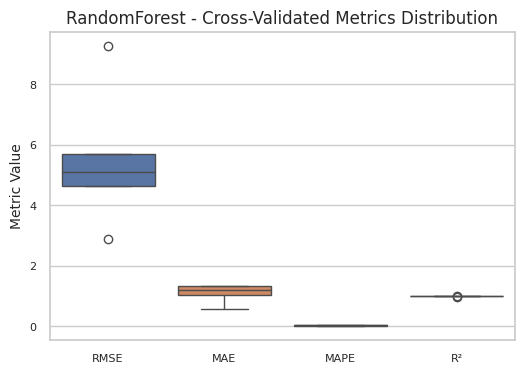



===== Evaluating HistGradientBoosting with Cross-Validation =====
Cross-Validated RMSE: 6.80
Cross-Validated RMSE Std: 2.16
Cross-Validated MAE: 2.05
Cross-Validated MAE Std: 0.30
Cross-Validated MAPE: 0.06
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.98
Cross-Validated R² Std: 0.01




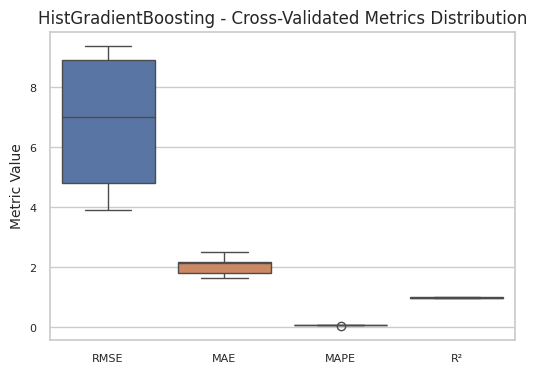



===== Evaluating XGBoost with Cross-Validation =====
Cross-Validated RMSE: 7.58
Cross-Validated RMSE Std: 2.22
Cross-Validated MAE: 1.94
Cross-Validated MAE Std: 0.39
Cross-Validated MAPE: 0.05
Cross-Validated MAPE Std: 0.00
Cross-Validated R²: 0.98
Cross-Validated R² Std: 0.01




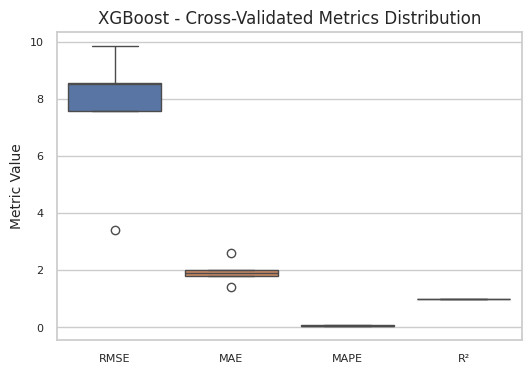



===== Evaluating LightGBM with Cross-Validation =====
Cross-Validated RMSE: 4.74
Cross-Validated RMSE Std: 0.81
Cross-Validated MAE: 1.81
Cross-Validated MAE Std: 0.24
Cross-Validated MAPE: 0.05
Cross-Validated MAPE Std: 0.00
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




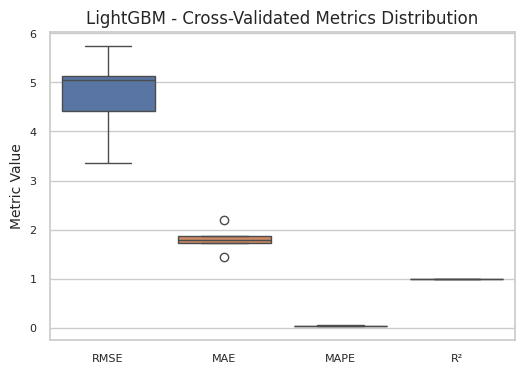



===== Evaluating CatBoost with Cross-Validation =====
Cross-Validated RMSE: 7.15
Cross-Validated RMSE Std: 1.57
Cross-Validated MAE: 3.30
Cross-Validated MAE Std: 0.55
Cross-Validated MAPE: 0.11
Cross-Validated MAPE Std: 0.02
Cross-Validated R²: 0.98
Cross-Validated R² Std: 0.01




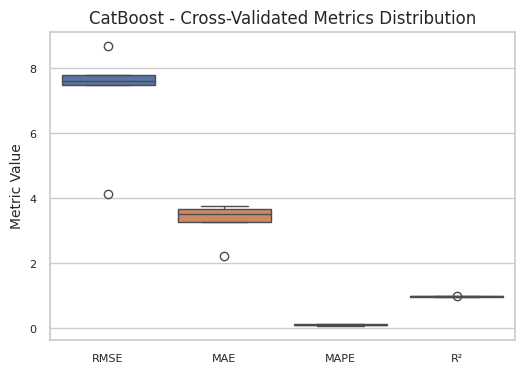

In [47]:
# Evaluate models using cross-validation
evaluation_results = evaluate_models_cross_validated(
    models,
    X_train,
    y_train,
    cv_splits=5
)

In [48]:
def select_best_model(evaluation_results, metric='Cross-Validated RMSE', minimize=True):
    """
    Select the best performing model based on a specified evaluation metric.

    Parameters:
    - evaluation_results (dict): Dictionary containing evaluation metrics for each model.
    - metric (str): The metric to base the selection on.
    - minimize (bool): Whether to minimize or maximize the metric.

    Returns:
    - best_model_name (str): The name of the best performing model.
    """
    best_score = None
    best_model_name = None

    for model_name, metrics in evaluation_results.items():
        score = metrics.get(metric, None)
        if score is None:
            continue
        if best_score is None:
            best_score = score
            best_model_name = model_name
        else:
            if minimize:
                if score < best_score:
                    best_score = score
                    best_model_name = model_name
            else:
                if score > best_score:
                    best_score = score
                    best_model_name = model_name

    print(f"===== Best Model Selected =====\nModel: {best_model_name} with {metric}: {best_score:.2f}")
    return best_model_name

In [49]:
# Identify the best model based on Cross-Validated RMSE
best_model_name = select_best_model(
    evaluation_results,
    metric='Cross-Validated RMSE',
    minimize=True
)
best_model_pipeline = models[best_model_name]

===== Best Model Selected =====
Model: LightGBM with Cross-Validated RMSE: 4.74


# Tune the Models

In [50]:
# Define hyperparameter mappings for each model with detailed metadata
HYPERPARAMETER_MAPPING = {
    'RandomForestRegressor': {
        'n_estimators': {
            'param_name': 'n_estimators',
            'type': 'int',
            'range': [100, 1000],
            'description': 'Number of trees in the forest.'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'type': 'int',
            'range': [10, 50],
            'allow_none': True,  # Allows unlimited depth
            'description': 'Maximum depth of each tree.'
        },
        'min_samples_split': {
            'param_name': 'min_samples_split',
            'type': 'int',
            'range': [2, 20],
            'description': 'Minimum number of samples required to split an internal node.'
        },
        'min_samples_leaf': {
            'param_name': 'min_samples_leaf',
            'type': 'int',
            'range': [1, 20],
            'description': 'Minimum number of samples required to be at a leaf node.'
        }
    },
    'HistGradientBoostingRegressor': {
        'n_estimators': {
            'param_name': 'max_iter',
            'type': 'int',
            'range': [100, 1000],
            'description': 'Number of boosting iterations.'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'type': 'int',
            'range': [10, 50],
            'description': 'Maximum depth of individual regression estimators.'
        },
        'min_samples_split': {
            'param_name': 'min_samples_split',
            'type': 'int',
            'range': [2, 20],
            'description': 'Minimum number of samples required to split an internal node.'
        },
        'min_samples_leaf': {
            'param_name': 'min_samples_leaf',
            'type': 'int',
            'range': [1, 20],
            'description': 'Minimum number of samples required to be at a leaf node.'
        },
        'learning_rate': {  # Model-specific hyperparameter
            'param_name': 'learning_rate',
            'type': 'float',
            'range': [0.01, 0.3],
            'description': 'Learning rate shrinks the contribution of each tree.'
        }
    },
    'LGBMRegressor': {
        'n_estimators': {
            'param_name': 'n_estimators',
            'type': 'int',
            'range': [100, 1000],
            'description': 'Number of boosting rounds.'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'type': 'int',
            'range': [10, 50],
            'description': 'Maximum tree depth for base learners.'
        },
        'min_child_samples': {  # Model-specific hyperparameter
            'param_name': 'min_child_samples',
            'type': 'int',
            'range': [5, 100],
            'description': 'Minimum number of data points in a child.'
        },
        'learning_rate': {  # Model-specific hyperparameter
            'param_name': 'learning_rate',
            'type': 'float',
            'range': [0.01, 0.3],
            'description': 'Learning rate shrinks the contribution of each tree.'
        },
        'subsample': {  # Model-specific hyperparameter
            'param_name': 'subsample',
            'type': 'float',
            'range': [0.5, 1.0],
            'description': 'Fraction of samples to be used for fitting the individual base learners.'
        }
    },
    'XGBRegressor': {
        'n_estimators': {
            'param_name': 'n_estimators',
            'type': 'int',
            'range': [100, 1000],
            'description': 'Number of gradient boosted trees.'
        },
        'max_depth': {
            'param_name': 'max_depth',
            'type': 'int',
            'range': [10, 50],
            'description': 'Maximum tree depth for base learners.'
        },
        'min_child_weight': {  # Model-specific hyperparameter
            'param_name': 'min_child_weight',
            'type': 'float',
            'range': [1.0, 10.0],
            'description': 'Minimum sum of instance weight (hessian) needed in a child.'
        },
        'learning_rate': {  # Model-specific hyperparameter
            'param_name': 'learning_rate',
            'type': 'float',
            'range': [0.01, 0.3],
            'description': 'Learning rate shrinks the contribution of each tree.'
        },
        'subsample': {  # Model-specific hyperparameter
            'param_name': 'subsample',
            'type': 'float',
            'range': [0.5, 1.0],
            'description': 'Subsample ratio of the training instances.'
        }
    },
    'CatBoostRegressor': {
        'n_estimators': {
            'param_name': 'iterations',
            'type': 'int',
            'range': [100, 1000],
            'description': 'Number of trees to grow.'
        },
        'max_depth': {
            'param_name': 'depth',
            'type': 'int',
            'range': [6, 16],
            'description': 'Depth of the trees.'
        },
        'min_data_in_leaf': {  # Model-specific hyperparameter
            'param_name': 'min_data_in_leaf',
            'type': 'int',
            'range': [1, 20],
            'description': 'Minimum number of samples required in a leaf.'
        },
        'learning_rate': {  # Model-specific hyperparameter
            'param_name': 'learning_rate',
            'type': 'float',
            'range': [0.01, 0.3],
            'description': 'Learning rate shrinks the contribution of each tree.'
        },
        'bagging_temperature': {  # Model-specific hyperparameter
            'param_name': 'bagging_temperature',
            'type': 'float',
            'range': [0.0, 1.0],
            'description': 'Controls the intensity of Bayesian bagging.'
        }
    },
    # 'StackingRegressor': {
    #     'final_estimator__n_estimators': {  # Assuming final estimator has this parameter
    #         'param_name': 'final_estimator__n_estimators',
    #         'type': 'int',
    #         'range': [100, 1000],
    #         'description': 'Number of estimators in the final estimator.'
    #     },
    #     'final_estimator__max_depth': {
    #         'param_name': 'final_estimator__max_depth',
    #         'type': 'int',
    #         'range': [10, 50],
    #         'description': 'Maximum depth of the final estimator.'
    #     },
    #     'final_estimator__min_samples_split': {
    #         'param_name': 'final_estimator__min_samples_split',
    #         'type': 'int',
    #         'range': [2, 20],
    #         'description': 'Minimum samples to split in the final estimator.'
    #     },
    #     'final_estimator__min_samples_leaf': {
    #         'param_name': 'final_estimator__min_samples_leaf',
    #         'type': 'int',
    #         'range': [1, 20],
    #         'description': 'Minimum samples per leaf in the final estimator.'
    #     },
    #     'final_estimator__learning_rate': {  # Model-specific hyperparameter if applicable
    #         'param_name': 'final_estimator__learning_rate',
    #         'type': 'float',
    #         'range': [0.01, 0.3],
    #         'description': 'Learning rate for the final estimator.'
    #     },
    #     'final_estimator__subsample': {  # Model-specific hyperparameter if applicable
    #         'param_name': 'final_estimator__subsample',
    #         'type': 'float',
    #         'range': [0.5, 1.0],
    #         'description': 'Subsample ratio for the final estimator.'
    #     }
    # },
}

## CMA-ES

In [51]:
def evaluate_solution_cma(params, model_pipeline, X, y, cv_splits, seed, model_name):
    """
    Evaluates a single set of hyperparameters using cross-validation.

    Parameters:
    - params (list or np.ndarray): List of hyperparameter values corresponding to the mapping.
    - model_pipeline (Pipeline): The pipeline containing preprocessing and regressor.
    - X (pd.DataFrame): Features.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - model_name (str): Name of the model being tuned.

    Returns:
    - avg_rmse (float): Average RMSE across cross-validation folds.
    """
    try:
        # Clone the pipeline to prevent shared state issues
        pipeline_clone = clone(model_pipeline)

        # Retrieve the mapping for the current model
        mapping = HYPERPARAMETER_MAPPING[model_name]

        # Initialize a dictionary to hold model-specific parameters
        model_specific_params = {}

        # Get the list of hyperparameters to tune
        hyperparams = list(mapping.keys())

        # Iterate through hyperparameters and assign values
        for i, generic_param in enumerate(hyperparams):
            param_info = mapping[generic_param]
            param_name = param_info['param_name']
            param_type = param_info['type']
            param_range = param_info['range']
            allow_none = param_info.get('allow_none', False)

            value = params[i]

            if param_type == 'int':
                if allow_none and value >= param_range[1]:
                    model_specific_params[param_name] = None
                else:
                    model_specific_params[param_name] = int(np.clip(value, param_range[0], param_range[1]))
            elif param_type == 'float':
                model_specific_params[param_name] = float(np.clip(value, param_range[0], param_range[1]))
            else:
                raise ValueError(f"Unsupported parameter type: {param_type}")

        # Set random state
        if 'random_state' in model_specific_params:
            model_specific_params['random_state'] = seed
        elif hasattr(pipeline_clone.named_steps['regressor'], 'random_state'):
            pipeline_clone.named_steps['regressor'].set_params(random_state=seed)

        # Set n_jobs=1 if the model supports it
        if hasattr(pipeline_clone.named_steps['regressor'], 'n_jobs'):
            pipeline_clone.named_steps['regressor'].set_params(n_jobs=1)

        # Set device if the model supports it
        if hasattr(pipeline_clone.named_steps['regressor'], 'device'):
            pipeline_clone.named_steps['regressor'].set_params(device='gpu')

        # Set hyperparameters
        pipeline_clone.named_steps['regressor'].set_params(**model_specific_params)

        # Get the class name of the regressor
        regressor_class_name = pipeline_clone.named_steps['regressor'].__class__.__name__

        # Set verbosity if the regressor's class name is 'LGBMRegressor'
        if regressor_class_name == 'LGBMRegressor':
            pipeline_clone.named_steps['regressor'].set_params(verbose=-1)

        # Define TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        for train_index, val_index in tscv.split(X):
            X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
            y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

            # Fit the model
            pipeline_clone.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = pipeline_clone.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Calculate the average RMSE
        avg_rmse = np.mean(rmse_scores)

        return avg_rmse
    except Exception as e:
        # If any error occurs, return a large RMSE to penalize the solution
        print(f"Exception in evaluate_solution_cma with params {params}: {e}")
        return float('inf')

In [52]:
def cma_es_hyperparameter_tuning(model_pipeline, X, y, cv_splits=5, seed=42,
                                 max_iterations=50, population_size=10, workers=None):
    """
    Perform hyperparameter tuning using CMA-ES with TimeSeriesSplit cross-validation for a Regressor.
    Incorporates parallel processing to evaluate multiple solutions simultaneously and enhanced progress reporting.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and regressor.
    - X (pd.DataFrame): Features.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - max_iterations (int): Maximum number of CMA-ES iterations.
    - population_size (int): Number of solutions per CMA-ES iteration.
    - workers (int): Number of parallel workers for evaluation. If None, uses all available cores.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Determine number of workers
    if workers is None:
        workers = multiprocessing.cpu_count()

    # Identify the model name from the pipeline
    regressor = model_pipeline.named_steps['regressor']
    model_class = regressor.__class__.__name__
    if model_class not in HYPERPARAMETER_MAPPING:
        raise ValueError(f"Model {model_class} is not supported for tuning.")

    # Retrieve the mapping for the current model
    mapping = HYPERPARAMETER_MAPPING[model_class]

    # Define hyperparameters to tune
    hyperparams = list(mapping.keys())

    # Define initial mean and step sizes based on hyperparameters
    initial_mean = []
    step_sizes = []
    bounds_lower = []
    bounds_upper = []
    for param in hyperparams:
        param_info = mapping[param]
        p_min, p_max = param_info['range']
        initial_mean.append((p_min + p_max) / 2)
        step_sizes.append((p_max - p_min) / 4)  # Example step size
        bounds_lower.append(p_min)
        bounds_upper.append(p_max)

    # Calculate a scalar sigma as the average step size
    sigma = np.mean(step_sizes)

    # Initialize CMA-ES optimizer
    es = cma.CMAEvolutionStrategy(initial_mean, sigma, {
        'bounds': [bounds_lower, bounds_upper],
        'popsize': population_size,
        'seed': seed,
        'verb_disp': 0  # Disable default verbosity to integrate with tqdm
    })

    # Initialize progress bar
    pbar = tqdm(total=max_iterations, desc="CMA-ES Tuning Progress", unit="iter")

    # Storage for best parameters and score
    best_score = float('inf')
    best_params = None

    # Initialize iteration counter
    current_iteration = 0

    while current_iteration < max_iterations:
        solutions = es.ask()

        # Evaluate solutions in parallel
        scores = Parallel(n_jobs=workers)(
            delayed(evaluate_solution_cma)(
                sol,
                model_pipeline=model_pipeline,
                X=X,
                y=y,
                cv_splits=cv_splits,
                seed=seed,
                model_name=model_class
            ) for sol in solutions
        )
        # Tell CMA-ES the scores
        es.tell(solutions, scores)

        # Update best score and parameters
        for sol, score in zip(solutions, scores):
            if score < best_score:
                best_score = score
                best_params = sol

        # Update progress bar with Best RMSE
        pbar.set_postfix({'Best RMSE': f"{best_score:.2f}"})
        pbar.update(1)

        # Increment iteration counter
        current_iteration += 1

    # Close progress bar
    pbar.close()

    # Check if best_params is not None
    if best_params is None:
        print("CMA-ES did not find any valid solutions.")
        return None, None

    # Convert best_params to a dictionary
    best_params_dict = {}
    for i, param in enumerate(hyperparams):
        param_info = mapping[param]
        param_type = param_info['type']
        param_range = param_info['range']
        allow_none = param_info.get('allow_none', False)
        value = best_params[i]

        if param_type == 'int':
            if allow_none and value >= param_range[1]:
                best_params_dict[param_info['param_name']] = None
            else:
                best_params_dict[param_info['param_name']] = int(np.clip(value, param_range[0], param_range[1]))
        elif param_type == 'float':
            best_params_dict[param_info['param_name']] = float(np.clip(value, param_range[0], param_range[1]))
        else:
            raise ValueError(f"Unsupported parameter type: {param_type}")

    # Set random state if applicable
    if 'random_state' in best_params_dict:
        best_params_dict['random_state'] = seed

    # Print the results
    print("\n===== CMA-ES Hyperparameter Tuning Completed =====")
    print(f"Best Parameters: {best_params_dict}")
    print(f"Best Cross-Validated RMSE: {best_score:.2f}")

    return best_params_dict, best_score

In [53]:
# Perform CMA-ES hyperparameter tuning with parallel processing
best_params_cma, best_score_cma = cma_es_hyperparameter_tuning(
    model_pipeline=best_model_pipeline,
    X=X_train,
    y=y_train,
    cv_splits=5,
    seed=42,
    max_iterations=5,
    population_size=10
)

CMA-ES Tuning Progress:   0%|          | 0/5 [00:00<?, ?iter/s]


===== CMA-ES Hyperparameter Tuning Completed =====
Best Parameters: {'n_estimators': 528, 'max_depth': 29, 'min_child_samples': 17, 'learning_rate': 0.07945182907083657, 'subsample': 0.7806621243658362}
Best Cross-Validated RMSE: 4.22


## Bayesian

In [54]:
def optuna_bayesian_tuning(model_pipeline, X, y, cv_splits=5, seed=42, n_trials=50):
    """
    Perform hyperparameter tuning using Optuna with TimeSeriesSplit cross-validation for a Regressor.
    Incorporates progress reporting using tqdm via a callback function.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and regressor.
    - X (pd.DataFrame): Features.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - n_trials (int): Number of optimization trials.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Initialize the progress bar
    progress_bar = tqdm(total=n_trials, desc="Optuna Tuning Progress", unit="trial")

    # Identify the model name from the pipeline
    regressor = model_pipeline.named_steps['regressor']
    model_class = regressor.__class__.__name__
    if model_class not in HYPERPARAMETER_MAPPING:
        raise ValueError(f"Model {model_class} is not supported for tuning.")

    # Retrieve the mapping for the current model
    mapping = HYPERPARAMETER_MAPPING[model_class]

    def objective(trial):
        # Initialize a dictionary to hold model-specific parameters
        model_specific_params = {}

        # Iterate over each generic hyperparameter
        for generic_param, param_info in mapping.items():
            param_name = param_info['param_name']
            param_type = param_info['type']
            param_range = param_info['range']
            allow_none = param_info.get('allow_none', False)

            # Suggest hyperparameters based on type
            if param_type == 'int':
                if allow_none:
                    # Include None as a possible option
                    choices = list(range(param_range[0], param_range[1]+1)) + [None]
                    value = trial.suggest_categorical(generic_param, choices)
                else:
                    value = trial.suggest_int(generic_param, param_range[0], param_range[1])
            elif param_type == 'float':
                value = trial.suggest_float(generic_param, param_range[0], param_range[1], log=True)
            else:
                raise ValueError(f"Unsupported parameter type: {param_type}")

            # Assign the suggested value to the model-specific parameter
            model_specific_params[param_name] = value

        # Set random state
        if 'random_state' in model_specific_params:
            model_specific_params['random_state'] = seed
        elif hasattr(model_pipeline.named_steps['regressor'], 'random_state'):
            model_pipeline.named_steps['regressor'].set_params(random_state=seed)

        # Set n_jobs=1 if the model supports it
        if hasattr(model_pipeline.named_steps['regressor'], 'n_jobs'):
            model_pipeline.named_steps['regressor'].set_params(n_jobs=1)

        # Set device if the model supports it
        if hasattr(model_pipeline.named_steps['regressor'], 'device'):
            model_pipeline.named_steps['regressor'].set_params(device='gpu')

        # Set hyperparameters
        model_pipeline.named_steps['regressor'].set_params(**model_specific_params)

        # Get the class name of the regressor
        regressor_class_name = model_pipeline.named_steps['regressor'].__class__.__name__

        # Set verbosity if the regressor's class name is 'LGBMRegressor'
        if regressor_class_name == 'LGBMRegressor':
            model_pipeline.named_steps['regressor'].set_params(verbose=-1)

        # Define TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        for train_index, val_index in tscv.split(X):
            X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
            y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

            # Fit the model
            model_pipeline.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = model_pipeline.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Calculate the average RMSE
        avg_rmse = np.mean(rmse_scores)

        # Report intermediate objective value
        trial.report(avg_rmse, step=1)

        # Prune trials that are not promising
        if trial.should_prune():
            raise TrialPruned()

        return avg_rmse

    def callback(study, trial):
        # Update the progress bar after each trial
        progress_bar.update(1)
        try:
            best_rmse = study.best_value
            progress_bar.set_postfix({'Best RMSE': f"{best_rmse:.2f}"})
        except ValueError:
            # No trials have been completed yet
            progress_bar.set_postfix({'Best RMSE': "N/A"})

    # Create a study object
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    # Optimize with the objective function and callback
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    # Close the progress bar
    progress_bar.close()

    # Retrieve the best parameters and corresponding RMSE
    best_params = study.best_params
    best_score = study.best_value

    # Adjust 'max_depth' if it's set to 'None'
    if 'max_depth' in best_params and mapping['max_depth'].get('allow_none', False):
        if best_params['max_depth'] is not None and best_params['max_depth'] >= mapping['max_depth']['range'][1]:
            best_params[mapping['max_depth']['param_name']] = None

    print("\n===== Optuna Bayesian Optimization Completed =====")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated RMSE: {best_score:.2f}")

    return best_params, best_score

In [55]:
# Perform Optuna Bayesian Optimization hyperparameter tuning
best_params_optuna, best_score_optuna = optuna_bayesian_tuning(
    best_model_pipeline,
    X=X_train,
    y=y_train,
    cv_splits=5,
    seed=42,
    n_trials=5
)

Optuna Tuning Progress:   0%|          | 0/5 [00:00<?, ?trial/s]

[I 2024-10-30 08:15:48,277] A new study created in memory with name: no-name-4bc157d7-c4ff-4b49-a4b0-e96d120495dc
[I 2024-10-30 08:16:05,809] Trial 0 finished with value: 5.598218775719336 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_child_samples': 75, 'learning_rate': 0.07661100707771368, 'subsample': 0.5571040234647635}. Best is trial 0 with value: 5.598218775719336.
[I 2024-10-30 08:16:15,601] Trial 1 finished with value: 6.032998025361972 and parameters: {'n_estimators': 240, 'max_depth': 12, 'min_child_samples': 88, 'learning_rate': 0.07725378389307355, 'subsample': 0.8168100814185651}. Best is trial 0 with value: 5.598218775719336.
[I 2024-10-30 08:16:21,838] Trial 2 finished with value: 9.526766850901684 and parameters: {'n_estimators': 118, 'max_depth': 49, 'min_child_samples': 84, 'learning_rate': 0.020589728197687916, 'subsample': 0.5671589285948462}. Best is trial 0 with value: 5.598218775719336.
[I 2024-10-30 08:16:33,268] Trial 3 finished with value: 5.1736


===== Optuna Bayesian Optimization Completed =====
Best Parameters: {'n_estimators': 651, 'max_depth': 15, 'min_child_samples': 33, 'learning_rate': 0.03476649150592621, 'subsample': 0.6858999160561153}
Best Cross-Validated RMSE: 4.58


## Genetic

In [56]:
def evaluate_solution_ga(individual, model_pipeline, X, y, cv_splits, seed, model_name):
    """
    Evaluates a single individual (set of hyperparameters) using cross-validation.

    Parameters:
    - individual (list): List of hyperparameter values corresponding to the mapping.
    - model_pipeline (Pipeline): The pipeline containing preprocessing and regressor.
    - X (pd.DataFrame): Features.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - model_name (str): Name of the model being tuned.

    Returns:
    - tuple: (avg_rmse,)
    """
    try:
        # Clone the pipeline to prevent shared state issues
        pipeline_clone = clone(model_pipeline)

        # Retrieve the mapping for the current model
        mapping = HYPERPARAMETER_MAPPING[model_name]

        # Initialize a dictionary to hold model-specific parameters
        model_specific_params = {}

        # Get the list of hyperparameters to tune
        hyperparams = list(mapping.keys())

        # Iterate through hyperparameters and assign values
        for i, generic_param in enumerate(hyperparams):
            param_info = mapping[generic_param]
            param_name = param_info['param_name']
            param_type = param_info['type']
            param_range = param_info['range']
            allow_none = param_info.get('allow_none', False)

            value = individual[i]

            if param_type == 'int':
                if allow_none and value >= param_range[1]:
                    model_specific_params[param_name] = None
                else:
                    model_specific_params[param_name] = int(np.clip(value, param_range[0], param_range[1]))
            elif param_type == 'float':
                model_specific_params[param_name] = float(np.clip(value, param_range[0], param_range[1]))
            else:
                raise ValueError(f"Unsupported parameter type: {param_type}")

        # Set random state
        if 'random_state' in model_specific_params:
            model_specific_params['random_state'] = seed
        elif hasattr(pipeline_clone.named_steps['regressor'], 'random_state'):
            pipeline_clone.named_steps['regressor'].set_params(random_state=seed)

        # Set n_jobs=1 if the model supports it
        if hasattr(pipeline_clone.named_steps['regressor'], 'n_jobs'):
            pipeline_clone.named_steps['regressor'].set_params(n_jobs=1)

        # Set device if the model supports it
        if hasattr(pipeline_clone.named_steps['regressor'], 'device'):
            pipeline_clone.named_steps['regressor'].set_params(device='gpu')

        # Set hyperparameters
        pipeline_clone.named_steps['regressor'].set_params(**model_specific_params)

        # Get the class name of the regressor
        regressor_class_name = pipeline_clone.named_steps['regressor'].__class__.__name__

        # Set verbosity if the regressor's class name is 'LGBMRegressor'
        if regressor_class_name == 'LGBMRegressor':
            pipeline_clone.named_steps['regressor'].set_params(verbose=-1)

        # Define TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        for train_index, val_index in tscv.split(X):
            X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
            y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

            # Fit the model
            pipeline_clone.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = pipeline_clone.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Calculate average RMSE across folds
        avg_rmse = np.mean(rmse_scores)

        # Return the average RMSE as a tuple
        return (avg_rmse,)
    except Exception as e:
        # If any error occurs, return a large RMSE to penalize the solution
        print(f"Exception in evaluate_solution_ga with params {individual}: {e}")
        return (float('inf'),)

In [57]:
def genetic_algorithm_tuning(model_pipeline, X, y, cv_splits=5, seed=42,
                             population_size=20, generations=10, workers=None):
    """
    Perform hyperparameter tuning using Genetic Algorithms with TimeSeriesSplit cross-validation for a Regressor.
    Incorporates enhanced progress reporting and parallel processing.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and regressor.
    - X (pd.DataFrame): Features.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations to evolve.
    - workers (int): Number of parallel workers for evaluation. If None, uses all available cores.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Determine number of workers
    if workers is None:
        workers = multiprocessing.cpu_count()

    # Identify the model name from the pipeline
    regressor = model_pipeline.named_steps['regressor']
    model_class = regressor.__class__.__name__
    if model_class not in HYPERPARAMETER_MAPPING:
        raise ValueError(f"Model {model_class} is not supported for tuning.")

    # Retrieve the mapping for the current model
    mapping = HYPERPARAMETER_MAPPING[model_class]

    # Define the optimization problem: minimize RMSE
    try:
        creator.create("FitnessMin_GA", base.Fitness, weights=(-1.0,))
    except AttributeError:
        # If already created, pass
        pass

    try:
        creator.create("Individual_GA", list, fitness=creator.FitnessMin_GA)
    except AttributeError:
        # If already created, pass
        pass

    toolbox = base.Toolbox()

    # Define the range for each hyperparameter
    for generic_param, param_info in mapping.items():
        param_type = param_info['type']
        param_range = param_info['range']
        if param_type == 'int':
            toolbox.register(generic_param, random.randint, param_range[0], param_range[1])
        elif param_type == 'float':
            toolbox.register(generic_param, random.uniform, param_range[0], param_range[1])
        else:
            raise ValueError(f"Unsupported parameter type: {param_type}")

    # Define how to create an individual
    hyperparams = list(mapping.keys())
    toolbox.register(
        "individual",
        tools.initCycle,
        creator.Individual_GA,
        tuple(toolbox.__getattribute__(param) for param in hyperparams),
        n=1
    )

    # Define how to create a population of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register the evaluation function with parallel processing
    toolbox.register(
        "evaluate",
        evaluate_solution_ga,
        model_pipeline=model_pipeline,
        X=X,
        y=y,
        cv_splits=cv_splits,
        seed=seed,
        model_name=model_class
    )

    # Register genetic operators
    # Use cxUniform for integer-friendly crossover
    toolbox.register("mate", tools.cxUniform, indpb=0.5)

    # Custom mutation: ensure mutated values stay within bounds
    def mutate(individual, indpb=0.2):
        for idx, generic_param in enumerate(hyperparams):
            if random.random() < indpb:
                param_info = mapping[generic_param]
                param_type = param_info['type']
                param_range = param_info['range']
                if param_type == 'int':
                    individual[idx] = random.randint(param_range[0], param_range[1])
                elif param_type == 'float':
                    individual[idx] = random.uniform(param_range[0], param_range[1])
        return (individual,)

    toolbox.register("mutate", mutate, indpb=0.2)

    # Selection: Tournament selection with tournament size of 3
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    population = toolbox.population(n=population_size)

    # Define statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Define hall of fame to store the best individuals
    hof = tools.HallOfFame(1)

    # Initialize progress bar for generations
    pbar = tqdm(total=generations, desc='GA Tuning Progress', unit='gen')

    # Run the Genetic Algorithm
    for generation in range(1, generations + 1):
        # --- Selection ---
        selected_parents = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, selected_parents))

        # --- Crossover ---
        for idx in range(0, len(offspring), 2):
            if idx + 1 >= len(offspring):
                break  # Prevent index out of range for odd population sizes
            parent1, parent2 = offspring[idx], offspring[idx + 1]
            if random.random() < 0.5:  # Crossover probability
                toolbox.mate(parent1, parent2)

                # Ensure hyperparameters are within valid bounds after crossover
                for i, generic_param in enumerate(hyperparams):
                    param_info = mapping[generic_param]
                    param_type = param_info['type']
                    param_range = param_info['range']
                    if param_type == 'int':
                        offspring[idx][i] = int(np.clip(offspring[idx][i], param_range[0], param_range[1]))
                        offspring[idx + 1][i] = int(np.clip(offspring[idx + 1][i], param_range[0], param_range[1]))
                    elif param_type == 'float':
                        offspring[idx][i] = float(np.clip(offspring[idx][i], param_range[0], param_range[1]))
                        offspring[idx + 1][i] = float(np.clip(offspring[idx + 1][i], param_range[0], param_range[1]))

                # Invalidate fitness since genetic operators have modified the individuals
                del offspring[idx].fitness.values
                del offspring[idx + 1].fitness.values

        # --- Mutation ---
        for mutant in offspring:
            if random.random() < 0.2:  # Mutation probability
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # --- Fitness Evaluation ---
        # Identify individuals with invalid (unevaluated) fitness
        individuals_to_evaluate = [ind for ind in offspring if not ind.fitness.valid]
        if individuals_to_evaluate:
            # Parallel evaluation of fitness using joblib
            fitness_results = Parallel(n_jobs=workers)(
                delayed(toolbox.evaluate)(ind) for ind in individuals_to_evaluate
            )
            # Assign the computed fitness values back to the individuals
            for individual, fitness in zip(individuals_to_evaluate, fitness_results):
                individual.fitness.values = fitness

        # Replace population with offspring
        population[:] = offspring

        # Update the hall of fame with the generated individuals
        hof.update(population)

        # Gather all the fitnesses in one list and compute statistics
        record = stats.compile(population)

        # Update progress bar
        pbar.set_postfix({
            'Best RMSE': f"{record['min']:.2f}",
            'Avg RMSE': f"{record['avg']:.2f}"
        })
        pbar.update(1)

    # Close progress bar
    pbar.close()

    # Extract the best individual
    best_ind = hof[0]
    best_rmse = best_ind.fitness.values[0]
    best_params = {}
    for i, generic_param in enumerate(hyperparams):
        param_info = mapping[generic_param]
        param_type = param_info['type']
        param_range = param_info['range']
        value = best_ind[i]
        if param_type == 'int':
            if param_info.get('allow_none', False) and value >= param_range[1]:
                best_params[param_info['param_name']] = None
            else:
                best_params[param_info['param_name']] = int(np.clip(value, param_range[0], param_range[1]))
        elif param_type == 'float':
            best_params[param_info['param_name']] = float(np.clip(value, param_range[0], param_range[1]))
        else:
            raise ValueError(f"Unsupported parameter type: {param_type}")

    # Set random state if applicable
    if 'random_state' in best_params:
        best_params['random_state'] = seed

    print("\n===== Genetic Algorithm Hyperparameter Tuning Completed =====")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

    return best_params, best_rmse

In [58]:
# Perform Genetic Algorithm hyperparameter tuning
best_params_ga, best_score_ga = genetic_algorithm_tuning(
    best_model_pipeline,
    X=X_train,
    y=y_train,
    cv_splits=5,
    seed=42,
    population_size=10,
    generations=5
)

GA Tuning Progress:   0%|          | 0/5 [00:00<?, ?gen/s]


===== Genetic Algorithm Hyperparameter Tuning Completed =====
Best Parameters: {'n_estimators': 212, 'max_depth': 20, 'min_child_samples': 25, 'learning_rate': 0.08671105149438378, 'subsample': 0.6908096432532684}
Best Cross-Validated RMSE: 4.50


# Retrain the Model

In [59]:
def retrain_model(model_pipeline, best_params, X_train, y_train, seed=42):
    """
    Retrain the given Regressor pipeline with the best hyperparameters.

    Parameters:
    - model_pipeline (Pipeline): The existing pipeline with preprocessing and regressor.
    - best_params (dict): Best hyperparameters found via tuning.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - seed (int): Random state for reproducibility.

    Returns:
    - retrained_pipeline (Pipeline): Retrained pipeline with optimal hyperparameters.
    """
    # Identify the model name from the pipeline
    regressor = model_pipeline.named_steps['regressor']
    model_class = regressor.__class__.__name__
    if model_class not in HYPERPARAMETER_MAPPING:
        raise ValueError(f"Model {model_class} is not supported for retraining.")

    # Retrieve the mapping for the current model
    mapping = HYPERPARAMETER_MAPPING[model_class]

    # Initialize a dictionary to hold model-specific parameters
    model_specific_params = {}

    # Handle each hyperparameter based on its type and range
    for generic_param, value in best_params.items():
        # Handle parameters specific to 'final_estimator' in StackingRegressor
        if model_class == 'StackingRegressor' and generic_param.startswith('final_estimator__'):
            param_info = mapping[generic_param]
            param_name = param_info['param_name']
            param_type = param_info['type']
            param_range = param_info['range']
            allow_none = param_info.get('allow_none', False)

            # Clip the value within the defined range
            if param_type == 'int':
                value = int(np.clip(value, param_range[0], param_range[1]))
            elif param_type == 'float':
                value = float(np.clip(value, param_range[0], param_range[1]))
                pass  # Extend as needed

            # Handle parameters that allow None
            if allow_none and value >= param_range[1]:
                model_specific_params[param_name] = None
            else:
                model_specific_params[param_name] = value

        else:
            # Regular hyperparameters
            param_info = mapping[generic_param]
            param_name = param_info['param_name']
            param_type = param_info['type']
            param_range = param_info['range']
            allow_none = param_info.get('allow_none', False)

            # Clip the value within the defined range
            if param_type == 'int':
                value = int(np.clip(value, param_range[0], param_range[1]))
            elif param_type == 'float':
                value = float(np.clip(value, param_range[0], param_range[1]))
                pass  # Extend as needed

            # Handle parameters that allow None
            if allow_none and value >= param_range[1]:
                model_specific_params[param_name] = None
            else:
                model_specific_params[param_name] = value

    # Set random state
    if 'random_state' in model_specific_params:
        model_specific_params['random_state'] = seed
    elif hasattr(model_pipeline.named_steps['regressor'], 'random_state'):
        model_pipeline.named_steps['regressor'].set_params(random_state=seed)

    # Set n_jobs=1 if the model supports it
    if hasattr(model_pipeline.named_steps['regressor'], 'n_jobs'):
        model_pipeline.named_steps['regressor'].set_params(n_jobs=1)

    # Set device if the model supports it
    if hasattr(model_pipeline.named_steps['regressor'], 'device'):
        model_pipeline.named_steps['regressor'].set_params(device='gpu')

    # Set hyperparameters
    model_pipeline.named_steps['regressor'].set_params(**model_specific_params)

    # Get the class name of the regressor
    regressor_class_name = model_pipeline.named_steps['regressor'].__class__.__name__

    # Set verbosity if the regressor's class name is 'LGBMRegressor'
    if regressor_class_name == 'LGBMRegressor':
        model_pipeline.named_steps['regressor'].set_params(verbose=-1)

    # Retrain the model on the entire training set
    model_pipeline.fit(X_train, y_train)
    print("===== Retrained Regressor with Best Hyperparameters =====")
    print(f"Hyperparameters: {best_params}")

    return model_pipeline

In [60]:
# Retrain the best model with CMA-ES tuned hyperparameters
retrained_cma = retrain_model(
    model_pipeline=best_model_pipeline,
    best_params=best_params_cma,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} CMA-ES Tuned'] = retrained_cma

===== Retrained Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 528, 'max_depth': 29, 'min_child_samples': 17, 'learning_rate': 0.07945182907083657, 'subsample': 0.7806621243658362}


In [61]:
# Retrain the best model with Optuna tuned hyperparameters
retrained_optuna = retrain_model(
    model_pipeline=best_model_pipeline,
    best_params=best_params_optuna,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} Optuna Tuned'] = retrained_optuna

===== Retrained Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 651, 'max_depth': 15, 'min_child_samples': 33, 'learning_rate': 0.03476649150592621, 'subsample': 0.6858999160561153}


In [62]:
# Retrain the best model with Genetic Algorithm tuned hyperparameters
retrained_ga = retrain_model(
    model_pipeline=best_model_pipeline,
    best_params=best_params_ga,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} GA Tuned'] = retrained_ga

===== Retrained Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 212, 'max_depth': 20, 'min_child_samples': 25, 'learning_rate': 0.08671105149438378, 'subsample': 0.6908096432532684}


===== Evaluating LightGBM CMA-ES Tuned with Cross-Validation =====
Cross-Validated RMSE: 4.50
Cross-Validated RMSE Std: 0.74
Cross-Validated MAE: 1.57
Cross-Validated MAE Std: 0.21
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.00
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




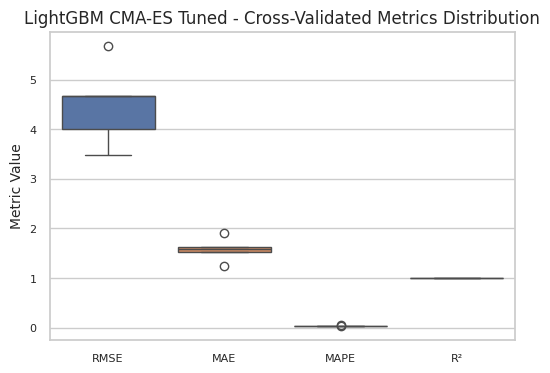

In [63]:
# Evaluate the CMA-ES tuned model using cross-validation
evaluation_results_tuned_cma = evaluate_models_cross_validated(
    {f'{best_model_name} CMA-ES Tuned': models[f'{best_model_name} CMA-ES Tuned']},
    X_train,
    y_train,
    cv_splits=5
)

===== Evaluating LightGBM Optuna Tuned with Cross-Validation =====
Cross-Validated RMSE: 4.50
Cross-Validated RMSE Std: 0.74
Cross-Validated MAE: 1.57
Cross-Validated MAE Std: 0.21
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.00
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




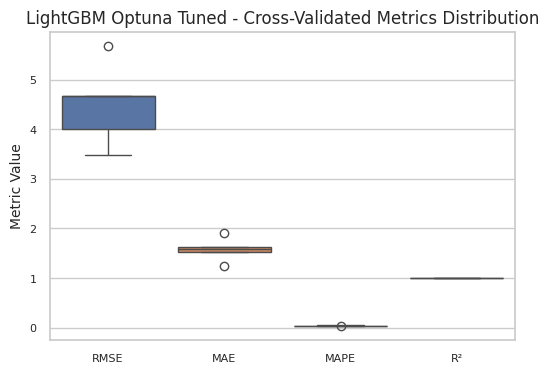

In [64]:
# Evaluate the Optuna tuned model using cross-validation
evaluation_results_tuned_optuna = evaluate_models_cross_validated(
    {f'{best_model_name} Optuna Tuned': models[f'{best_model_name} Optuna Tuned']},
    X_train,
    y_train,
    cv_splits=5
)

===== Evaluating LightGBM GA Tuned with Cross-Validation =====
Cross-Validated RMSE: 4.50
Cross-Validated RMSE Std: 0.74
Cross-Validated MAE: 1.57
Cross-Validated MAE Std: 0.21
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.00
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




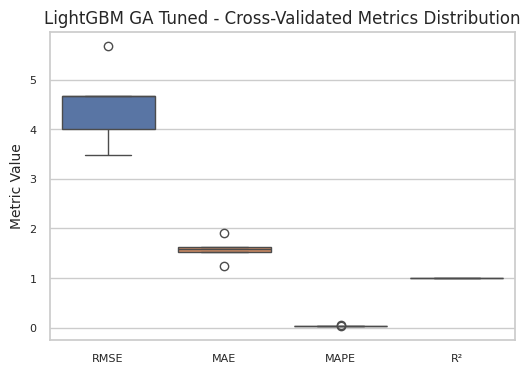

In [65]:
# Evaluate the GA tuned model using cross-validation
evaluation_results_tuned_ga = evaluate_models_cross_validated(
    {f'{best_model_name} GA Tuned': models[f'{best_model_name} GA Tuned']},
    X_train,
    y_train,
    cv_splits=5
)

In [66]:
def save_model(model_pipeline, model_path='model_pipeline.joblib', preprocessor_path='preprocessor.joblib'):
    """
    Save the trained model pipeline and preprocessor to disk.

    Parameters:
    - model_pipeline (Pipeline): Trained pipeline containing preprocessing and regressor.
    - model_path (str): File path to save the model.
    - preprocessor_path (str): File path to save the preprocessor.

    Returns:
    - None
    """
    # Save the entire pipeline (includes preprocessor and model)
    joblib.dump(model_pipeline, model_path)
    print(f"Model pipeline saved to {model_path}")

    # Extract and save the preprocessor separately if needed
    preprocessor = model_pipeline.named_steps['preprocessor']
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Preprocessor saved to {preprocessor_path}")

In [67]:
# # Save the tuned models and preprocessors
# for tuning_method in ['CMA-ES', 'Optuna', 'GA']:
#     model_name = f'{best_model_name} {tuning_method} Tuned'
#     model_pipeline = models.get(model_name, None)
#     if model_pipeline:
#         model_file = f"{model_name.replace(' ', '_').lower()}_pipeline.joblib"
#         preprocessor_file = f"preprocessor_{tuning_method.lower()}.joblib"
#         save_model(model_pipeline, model_path=model_file, preprocessor_path=preprocessor_file)
#         print("\n")
#     else:
#         print(f"Model '{model_name}' not found. Skipping save.")

In [68]:
def performance_comparison(evaluation_cma, evaluation_optuna, evaluation_ga):
    """
    Compare the performance of models tuned via CMA-ES, Optuna, and Genetic Algorithms.

    Parameters:
    - evaluation_cma (dict): Evaluation metrics from CMA-ES tuned model.
    - evaluation_optuna (dict): Evaluation metrics from Optuna tuned model.
    - evaluation_ga (dict): Evaluation metrics from Genetic Algorithm tuned model.

    Returns:
    - None
    """
    # Consolidate evaluation metrics
    comparison_df = pd.DataFrame({
        'CMA-ES Tuned': evaluation_cma[next(iter(evaluation_cma))],
        'Optuna Tuned': evaluation_optuna[next(iter(evaluation_optuna))],
        'GA Tuned': evaluation_ga[next(iter(evaluation_ga))]
    })

    # Transpose for better visualization
    comparison_df = comparison_df.transpose()

    print("===== Performance Comparison =====")
    display(comparison_df)
    print("\n")

    # Plotting the comparison
    comparison_df.plot(kind='bar', figsize=(7, 4))
    plt.title('Performance Comparison of Tuned Models')
    plt.ylabel('Metric Value')
    plt.xlabel('Tuning Method')
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), title='Metrics', title_fontsize='small', loc='upper left', prop={'size': 8})
    plt.tight_layout()
    plt.show()

===== Performance Comparison =====


,Cross-Validated RMSE,Cross-Validated RMSE Std,Cross-Validated MAE,Cross-Validated MAE Std,Cross-Validated MAPE,Cross-Validated MAPE Std,Cross-Validated R²,Cross-Validated R² Std
CMA-ES Tuned,4.504565,0.740518,1.574139,0.213064,0.039585,0.002549,0.993545,0.001613
Optuna Tuned,4.504734,0.740894,1.574015,0.212927,0.039528,0.002479,0.993546,0.001611
GA Tuned,4.503990,0.740846,1.573855,0.213208,0.039580,0.002544,0.993550,0.001611


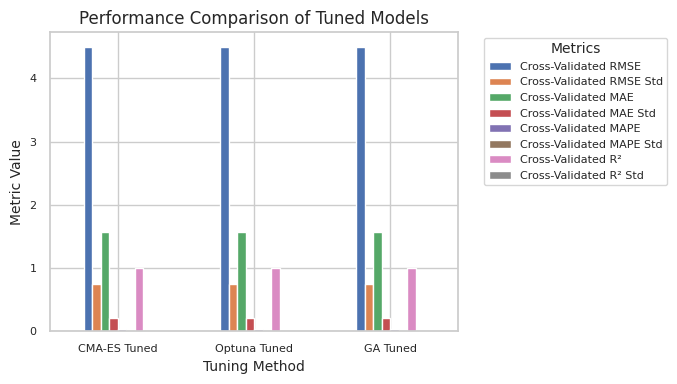

In [69]:
# Compare the performance of all tuned models
performance_comparison(
    evaluation_results_tuned_cma,
    evaluation_results_tuned_optuna,
    evaluation_results_tuned_ga
)

# Holdout Evaluations

In [70]:
def create_best_models_dict(models, best_model_name):
    """
    Extracts the tuned models from the 'models' dictionary and organizes them into 'best_models'.

    Parameters:
    ----------
    models : dict
        Dictionary containing all tuned models.
    best_model_name : str
        The base name of the best model (e.g., 'RandomForest').

    Returns:
    -------
    dict
        Dictionary containing the three tuned models.
    """
    best_models = {
        f'{best_model_name} CMA-ES Tuned': models[f'{best_model_name} CMA-ES Tuned'],
        f'{best_model_name} Optuna Tuned': models[f'{best_model_name} Optuna Tuned'],
        f'{best_model_name} GA Tuned': models[f'{best_model_name} GA Tuned']
    }
    return best_models

In [71]:
# Create best_models object
best_models = create_best_models_dict(models, best_model_name)

In [72]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluates a trained model on a given dataset and returns performance metrics.

    Parameters:
    ----------
    model : sklearn estimator
        The trained machine learning model.
    X : pd.DataFrame or np.ndarray
        Feature set.
    y : pd.Series or np.ndarray
        True target values.
    dataset_name : str, optional
        Name of the dataset (e.g., 'Validation', 'Test'), by default "Dataset".

    Returns:
    -------
    dict
        Dictionary containing performance metrics.
    """
    # Generate predictions
    y_pred = model.predict(X)

    # Calculate metrics
    rmse = mean_squared_error(y, y_pred, squared=False)  # RMSE
    mae = mean_absolute_error(y, y_pred)                 # MAE
    mape = mean_absolute_percentage_error(y, y_pred)     # MAPE
    r2 = r2_score(y, y_pred)                             # R²

    # Print metrics
    print(f"===== {dataset_name} Set Evaluation =====")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.2f}\n")

    # Plot actual vs. predicted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y, y=y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
    plt.title(f'{model.__class__.__name__} - Actual vs. Predicted on {dataset_name} Set')
    plt.xlabel('Actual Units Sold')
    plt.ylabel('Predicted Units Sold')
    plt.tight_layout()
    plt.show()
    print("\n")

    # Return metrics as a dictionary
    metrics = {
        'Dataset': dataset_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

    return metrics

In [73]:
def evaluate_multiple_models(best_models, X_val, y_val, X_test, y_test):
    """
    Evaluates multiple models on both validation and test sets and aggregates the results.

    Parameters:
    ----------
    best_models : dict
        Dictionary of trained and tuned models.
    X_val : pd.DataFrame or np.ndarray
        Validation feature set.
    y_val : pd.Series or np.ndarray
        Validation target values.
    X_test : pd.DataFrame or np.ndarray
        Test feature set.
    y_test : pd.Series or np.ndarray
        Test target values.

    Returns:
    -------
    pd.DataFrame
        DataFrame containing performance metrics for all models on both datasets.
    """
    # Initialize a list to store results
    results = []

    for model_name, model in best_models.items():
        print(f"===== Evaluating {model_name} on Validation Set =====")
        val_metrics = evaluate_model(model, X_val, y_val, dataset_name="Validation")
        val_metrics['Model'] = model_name
        results.append(val_metrics)

        print(f"===== Evaluating {model_name} on Test Set =====")
        test_metrics = evaluate_model(model, X_test, y_test, dataset_name="Test")
        test_metrics['Model'] = model_name
        results.append(test_metrics)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Rearrange columns for clarity
    cols = ['Model', 'Dataset', 'RMSE', 'MAE', 'MAPE', 'R²']
    results_df = results_df[cols]

    return results_df

===== Evaluating LightGBM CMA-ES Tuned on Validation Set =====
===== Validation Set Evaluation =====
RMSE: 3.82
MAE: 1.39
MAPE: 0.04%
R²: 1.00



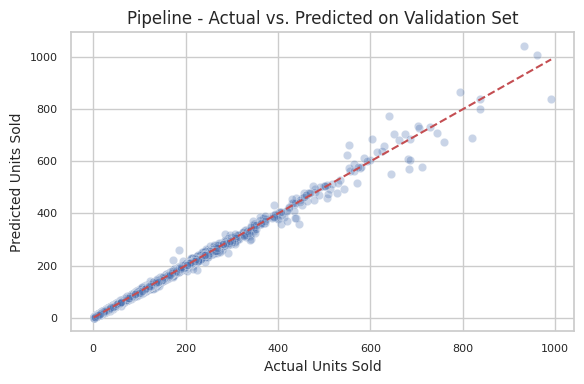



===== Evaluating LightGBM CMA-ES Tuned on Test Set =====
===== Test Set Evaluation =====
RMSE: 2.92
MAE: 1.34
MAPE: 0.04%
R²: 1.00



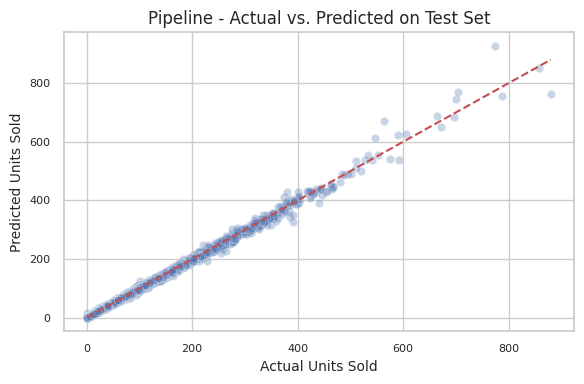



===== Evaluating LightGBM Optuna Tuned on Validation Set =====
===== Validation Set Evaluation =====
RMSE: 3.82
MAE: 1.39
MAPE: 0.04%
R²: 1.00



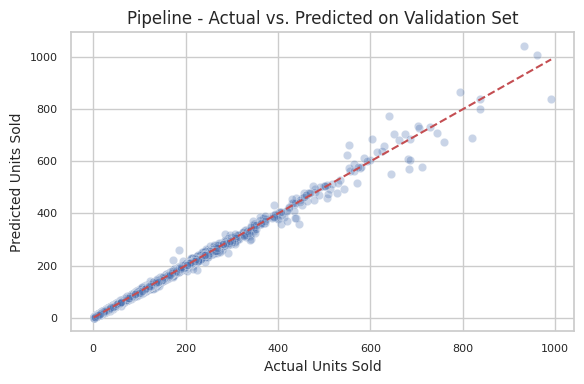



===== Evaluating LightGBM Optuna Tuned on Test Set =====
===== Test Set Evaluation =====
RMSE: 2.92
MAE: 1.34
MAPE: 0.04%
R²: 1.00



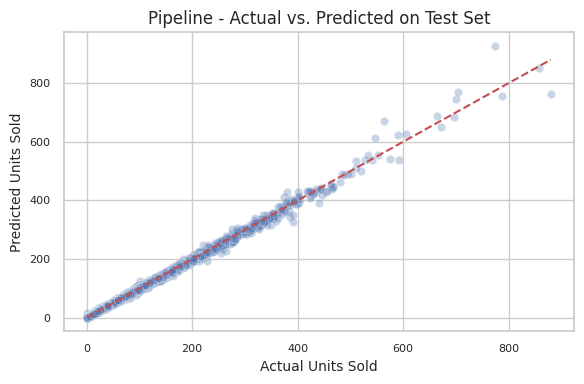



===== Evaluating LightGBM GA Tuned on Validation Set =====
===== Validation Set Evaluation =====
RMSE: 3.82
MAE: 1.39
MAPE: 0.04%
R²: 1.00



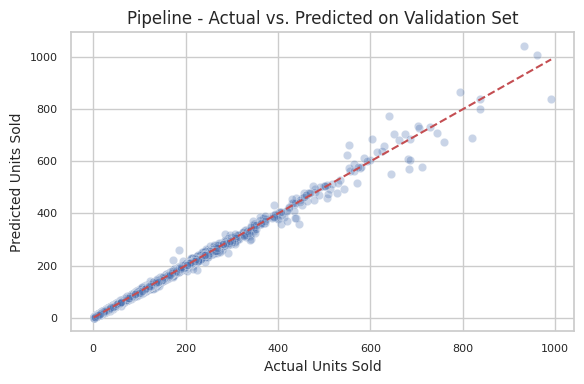



===== Evaluating LightGBM GA Tuned on Test Set =====
===== Test Set Evaluation =====
RMSE: 2.92
MAE: 1.34
MAPE: 0.04%
R²: 1.00



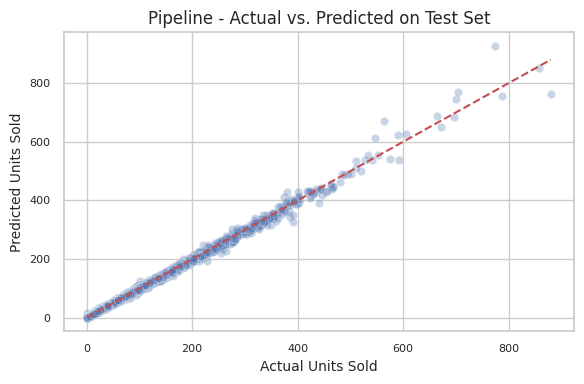



===== Aggregated Evaluation Results =====


,Model,Dataset,RMSE,MAE,MAPE,R²
0,LightGBM CMA-ES Tuned,Validation,3.823004,1.392920,0.035844,0.995838
1,LightGBM CMA-ES Tuned,Test,2.924898,1.341832,0.037558,0.997153
2,LightGBM Optuna Tuned,Validation,3.823004,1.392920,0.035844,0.995838
3,LightGBM Optuna Tuned,Test,2.924898,1.341832,0.037558,0.997153
4,LightGBM GA Tuned,Validation,3.823004,1.392920,0.035844,0.995838
5,LightGBM GA Tuned,Test,2.924898,1.341832,0.037558,0.997153


In [74]:
# Evaluate the models
results_df = evaluate_multiple_models(
    best_models,
    X_val,
    y_val,
    X_test,
    y_test
)

# Display the aggregated results
print("===== Aggregated Evaluation Results =====")
display(results_df)

In [75]:
def compare_model_performances(results_df):
    """
    Compares model performances based on evaluation metrics.

    Parameters:
    ----------
    results_df : pd.DataFrame
        DataFrame containing performance metrics for all models on both datasets.

    Returns:
    -------
    None
    """
    # Pivot the DataFrame for easier comparison
    pivot_df = results_df.pivot(index='Model', columns='Dataset', values=['RMSE', 'MAE', 'MAPE', 'R²'])

    # Flatten MultiIndex columns
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

    # Reset index to turn Model into a column
    pivot_df = pivot_df.reset_index()

    print("===== Model Performance Comparison =====\n")
    display(pivot_df)

    # Visualization: Bar plots for each metric
    metrics = ['RMSE', 'MAE', 'MAPE', 'R²']

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        sns.barplot(x='Model', y=f'{metric}_Validation', data=pivot_df, color='skyblue', label='Validation')
        sns.barplot(x='Model', y=f'{metric}_Test', data=pivot_df, color='salmon', label='Test')
        plt.title(f'Model Comparison on {metric}')
        plt.ylabel(metric)
        plt.ylim(0, pivot_df[f'{metric}_Validation'].max() * 1.2)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Dataset', prop={'size': 8})
        plt.tight_layout()
        plt.show()

In [76]:
def compare_model_performances(results_df):
    """
    Compares model performances based on evaluation metrics.

    Parameters:
    ----------
    results_df : pd.DataFrame
        DataFrame containing performance metrics for all models on both datasets.

    Returns:
    -------
    None
    """
    # Pivot the DataFrame for easier comparison
    pivot_df = results_df.pivot(index='Model', columns='Dataset', values=['RMSE', 'MAE', 'MAPE', 'R²'])

    # Reorder the columns to have Validation before Test for each metric
    metrics = ['RMSE', 'MAE', 'MAPE', 'R²']
    datasets = ['Validation', 'Test']
    desired_columns = [(metric, dataset) for metric in metrics for dataset in datasets]
    pivot_df = pivot_df[desired_columns]

    # Flatten MultiIndex columns
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

    # Reset index to turn Model into a column
    pivot_df = pivot_df.reset_index()

    print("===== Model Performance Comparison =====\n")
    display(pivot_df)
    print("\n")

    # Melt the pivot_df to long format for plotting
    melted_df = pd.melt(pivot_df, id_vars=['Model'], var_name='Metric_Dataset', value_name='Value')

    # Split 'Metric_Dataset' into 'Metric' and 'Dataset'
    melted_df[['Metric', 'Dataset']] = melted_df['Metric_Dataset'].str.split('_', expand=True)

    # Visualization: Grouped bar plots for each metric
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        data_to_plot = melted_df[melted_df['Metric'] == metric]

        # Plot
        palette = {'Validation': 'skyblue', 'Test': 'salmon'}
        ax = sns.barplot(x='Model', y='Value', hue='Dataset', data=data_to_plot, palette=palette)
        plt.title(f'Model Comparison on {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.ylim(0, pivot_df[f'{metric}_Validation'].max() * 1.2)
        plt.legend(bbox_to_anchor=(1.05, 1), title='Dataset', title_fontsize='small', loc='upper left', prop={'size': 8})
        plt.tight_layout()

        # Add text labels on the bars
        for p, value in zip(ax.patches, data_to_plot['Value']):
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2.,
                height + (pivot_df[f'{metric}_Validation'].max() * 0.01),
                '{:0.3f}'.format(value),
                ha="center",
                va='bottom',
                fontsize=8
            )

        plt.show()

===== Model Performance Comparison =====



,Model,RMSE_Validation,RMSE_Test,MAE_Validation,MAE_Test,MAPE_Validation,MAPE_Test,R²_Validation,R²_Test
0,LightGBM CMA-ES Tuned,3.823004,2.924898,1.39292,1.341832,0.035844,0.037558,0.995838,0.997153
1,LightGBM GA Tuned,3.823004,2.924898,1.39292,1.341832,0.035844,0.037558,0.995838,0.997153
2,LightGBM Optuna Tuned,3.823004,2.924898,1.39292,1.341832,0.035844,0.037558,0.995838,0.997153


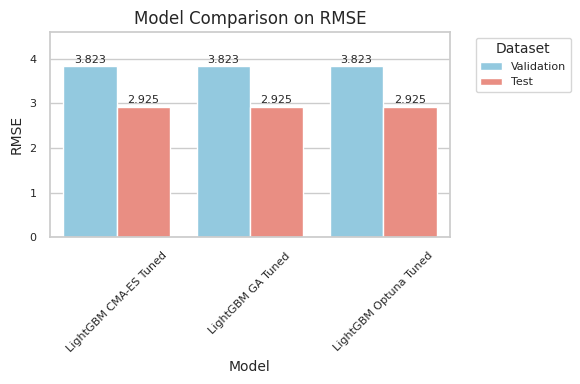

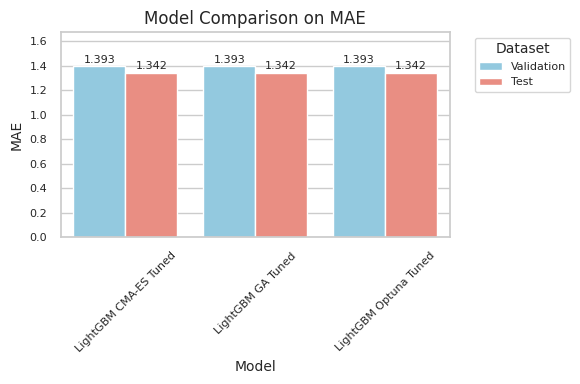

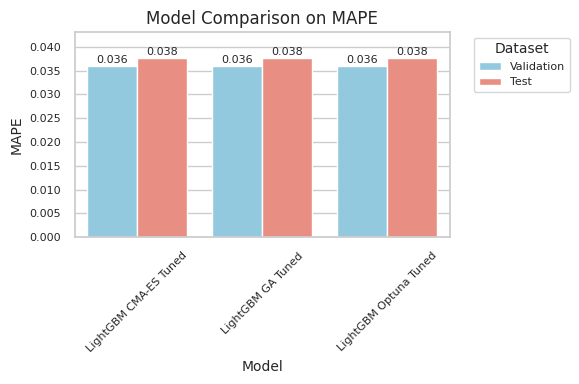

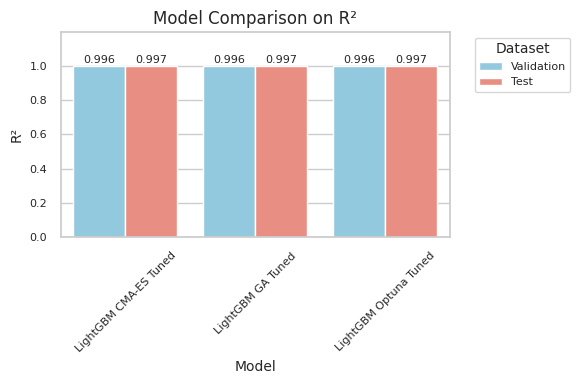

In [77]:
# Compare the performances
compare_model_performances(results_df)

# Feature Importance

In [78]:
def plot_feature_importance(model_pipeline, top_n=20):
    """
    Plot the feature importance for tree-based models.

    Parameters:
    - model_pipeline (Pipeline): Trained pipeline containing the regressor.
    - top_n (int): Number of top features to display.

    Returns:
    - None
    """
    # Extract the regressor from the pipeline
    regressor = model_pipeline.named_steps['regressor']

    # Check if the model has feature_importances_
    if not hasattr(regressor, 'feature_importances_'):
        print(f"Model '{type(regressor).__name__}' does not have feature_importances_ attribute.")
        return

    # Get feature importances
    importances = regressor.feature_importances_

    # Attempt to get feature names after preprocessing
    feature_names = None

    # Try to get feature names from the preprocessor
    if 'preprocessor' in model_pipeline.named_steps:
        preprocessor = model_pipeline.named_steps['preprocessor']
        if hasattr(preprocessor, 'get_feature_names_out'):
            try:
                feature_names = preprocessor.get_feature_names_out()
            except:
                pass

    # Try to get feature names from the pipeline
    if feature_names is None and hasattr(model_pipeline, 'get_feature_names_out'):
        try:
            feature_names = model_pipeline.get_feature_names_out()
        except:
            pass

    # Try to get feature names from the regressor
    if feature_names is None and hasattr(regressor, 'feature_names_in_'):
        feature_names = regressor.feature_names_in_

    # If feature names are still not found, use generic names
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]

    # Ensure the number of feature names matches the number of importances
    if len(feature_names) != len(importances):
        print(f"Warning: Mismatch between number of feature names ({len(feature_names)}) and importances ({len(importances)}). Adjusting.")
        min_len = min(len(feature_names), len(importances))
        feature_names = feature_names[:min_len]
        importances = importances[:min_len]

    # Create a DataFrame
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print("\n")

===== Feature Importance for LightGBM CMA-ES Tuned =====


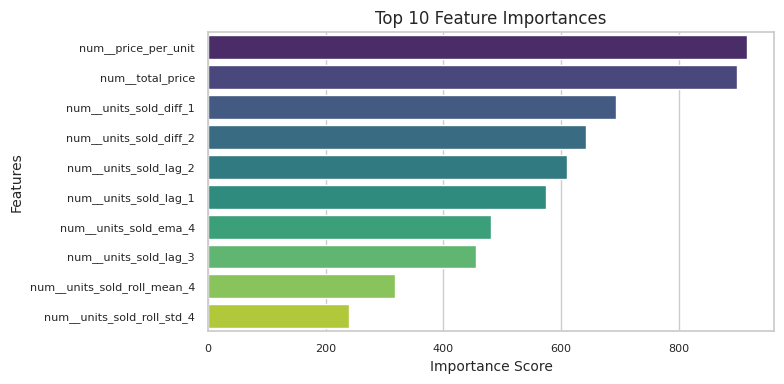



===== Feature Importance for LightGBM Optuna Tuned =====


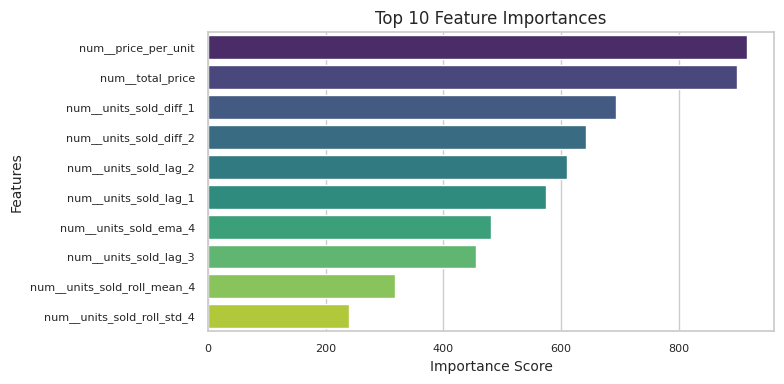



===== Feature Importance for LightGBM GA Tuned =====


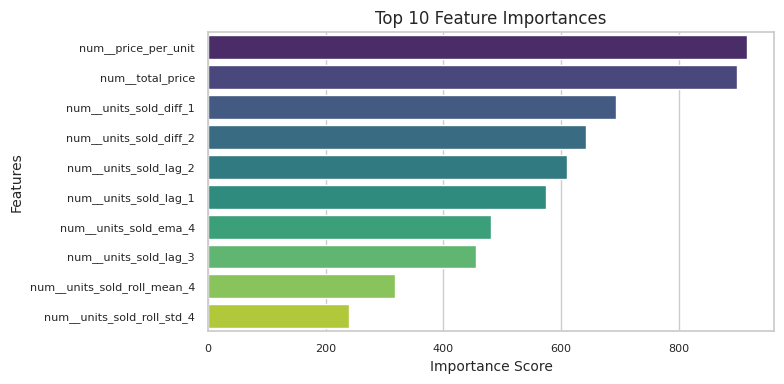

In [79]:
# Feature importance for tuned models
tuned_models = [f'{best_model_name} CMA-ES Tuned',
                f'{best_model_name} Optuna Tuned',
                f'{best_model_name} GA Tuned']

for model_name in tuned_models:
    if model_name in models:
        print(f"===== Feature Importance for {model_name} =====")
        plot_feature_importance(models[model_name], top_n=10)
    else:
        print(f"Model '{model_name}' not found in the models dictionary.")

In [80]:
def cross_val_feature_importance(model_pipeline, X, y, cv_splits=5, top_n=20):
    """
    Perform time-aware cross-validated feature importance analysis for tree-based models.

    Parameters:
    - model_pipeline (Pipeline): Pipeline containing preprocessing and the regressor.
    - X (pd.DataFrame): Feature data.
    - y (pd.Series): Target variable.
    - cv_splits (int): Number of cross-validation splits.
    - top_n (int): Number of top features to display.

    Returns:
    - None
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    # Initialize a list to store feature importances per fold
    feature_importances = []

    # Iterate over each fold
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing Fold {fold + 1}/{cv_splits}")

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Clone the pipeline to ensure independence across folds
        cloned_pipeline = clone(model_pipeline)

        # Fit the model
        cloned_pipeline.fit(X_train, y_train)

        # Extract feature importances
        regressor = cloned_pipeline.named_steps['regressor']
        if hasattr(regressor, 'feature_importances_'):
            importances = regressor.feature_importances_

            # Attempt to get feature names after preprocessing
            if hasattr(cloned_pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
                current_feature_names = cloned_pipeline.named_steps['preprocessor'].get_feature_names_out()
            elif hasattr(cloned_pipeline, 'get_feature_names_out'):
                current_feature_names = cloned_pipeline.get_feature_names_out()
            else:
                # Use X.columns as feature names
                current_feature_names = X.columns.tolist()

            # Check if lengths match
            if len(current_feature_names) != len(importances):
                print(f"Warning: Mismatch between number of feature names ({len(current_feature_names)}) and importances ({len(importances)}).")
                # Adjust feature names to match importances
                min_len = min(len(current_feature_names), len(importances))
                current_feature_names = current_feature_names[:min_len]
                importances = importances[:min_len]
            else:
                pass  # Lengths match, proceed as normal

            # Create a dict of feature importances
            importances_dict = dict(zip(current_feature_names, importances))
            feature_importances.append(importances_dict)
            print(f"Fold {fold + 1} Feature Importances Extracted.\n")
        else:
            print(f"Model '{type(regressor).__name__}' does not have feature_importances_ attribute.\n")
            return

    # Convert list of dicts to DataFrame, filling missing values with 0
    feature_importances_df = pd.DataFrame(feature_importances).fillna(0)

    # Calculate mean and standard deviation of importances across folds
    mean_importances = feature_importances_df.mean()
    std_importances = feature_importances_df.std()

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Feature': mean_importances.index,
        'Mean Importance': mean_importances.values,
        'Std': std_importances.values
    })

    # Sort features by mean importance
    plot_data = plot_data.sort_values('Mean Importance', ascending=False).head(top_n).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x='Mean Importance',
        y='Feature',
        data=plot_data,
        palette='viridis',
        ci=None,  # Disable default confidence interval
        edgecolor='w'
    )

    # Add error bars manually
    for i, (mean, std) in enumerate(zip(plot_data['Mean Importance'], plot_data['Std'])):
        ax.errorbar(
            x=mean,
            y=i,  # Positions are from 0 to n-1
            xerr=std,
            fmt='none',
            c='black',
            capsize=5
        )

    plt.title(f'Top {top_n} Feature Importances (Cross-Validated)')
    plt.xlabel('Mean Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nFeature Importances (Mean and Std) Across Folds:")
    display(plot_data)
    print("\n")

===== Cross-Validated Feature Importance for LightGBM CMA-ES Tuned =====
Processing Fold 1/5
Fold 1 Feature Importances Extracted.

Processing Fold 2/5
Fold 2 Feature Importances Extracted.

Processing Fold 3/5
Fold 3 Feature Importances Extracted.

Processing Fold 4/5
Fold 4 Feature Importances Extracted.

Processing Fold 5/5
Fold 5 Feature Importances Extracted.



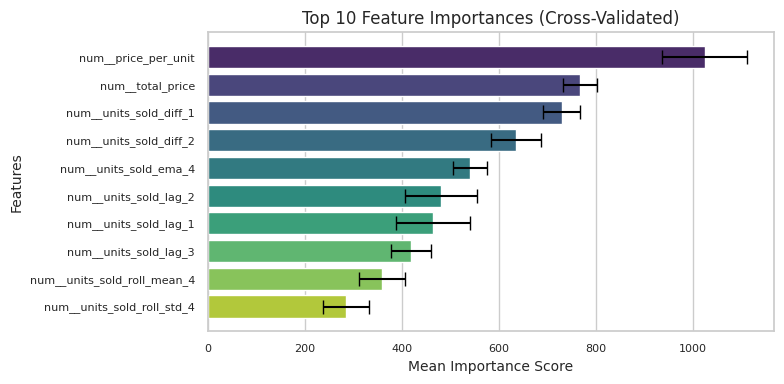


Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,num__price_per_unit,1023.4,87.631615
1,num__total_price,766.8,35.052817
2,num__units_sold_diff_1,728.6,38.552562
3,num__units_sold_diff_2,634.0,51.346860
4,num__units_sold_ema_4,540.0,34.300146
5,num__units_sold_lag_2,479.2,74.146477
6,num__units_sold_lag_1,463.4,75.876874
7,num__units_sold_lag_3,418.6,40.954853
8,num__units_sold_roll_mean_4,358.6,47.220758
9,num__units_sold_roll_std_4,284.6,46.960622




===== Cross-Validated Feature Importance for LightGBM Optuna Tuned =====
Processing Fold 1/5
Fold 1 Feature Importances Extracted.

Processing Fold 2/5
Fold 2 Feature Importances Extracted.

Processing Fold 3/5
Fold 3 Feature Importances Extracted.

Processing Fold 4/5
Fold 4 Feature Importances Extracted.

Processing Fold 5/5
Fold 5 Feature Importances Extracted.



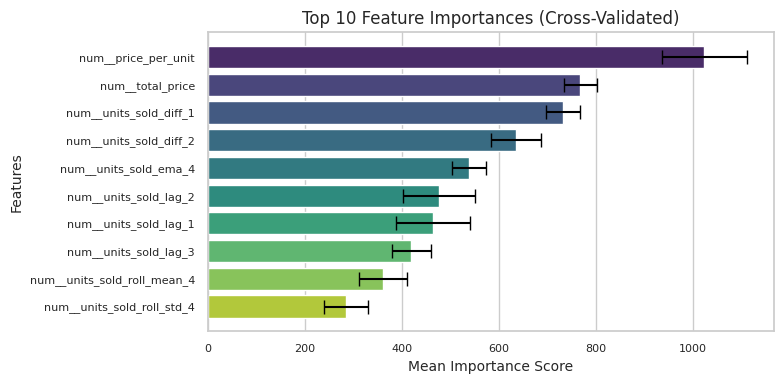


Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,num__price_per_unit,1023.0,87.860685
1,num__total_price,767.4,34.868324
2,num__units_sold_diff_1,731.4,35.802235
3,num__units_sold_diff_2,635.0,51.200586
4,num__units_sold_ema_4,537.8,35.435858
5,num__units_sold_lag_2,476.6,74.032425
6,num__units_sold_lag_1,463.0,75.917719
7,num__units_sold_lag_3,419.0,40.205721
8,num__units_sold_roll_mean_4,360.0,49.117207
9,num__units_sold_roll_std_4,283.8,45.427965




===== Cross-Validated Feature Importance for LightGBM GA Tuned =====
Processing Fold 1/5
Fold 1 Feature Importances Extracted.

Processing Fold 2/5
Fold 2 Feature Importances Extracted.

Processing Fold 3/5
Fold 3 Feature Importances Extracted.

Processing Fold 4/5
Fold 4 Feature Importances Extracted.

Processing Fold 5/5
Fold 5 Feature Importances Extracted.



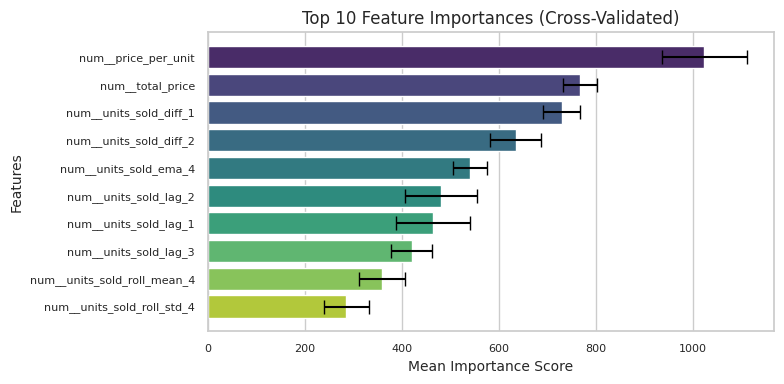


Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,num__price_per_unit,1023.0,87.758191
1,num__total_price,766.8,35.052817
2,num__units_sold_diff_1,728.6,38.552562
3,num__units_sold_diff_2,633.8,51.896050
4,num__units_sold_ema_4,540.0,34.300146
5,num__units_sold_lag_2,479.4,74.174119
6,num__units_sold_lag_1,463.4,75.876874
7,num__units_sold_lag_3,419.2,41.487347
8,num__units_sold_roll_mean_4,358.6,47.220758
9,num__units_sold_roll_std_4,284.6,46.629390


In [81]:
# Cross-validated feature importance for tuned models
for model_name in tuned_models:
    if model_name in models:
        print(f"===== Cross-Validated Feature Importance for {model_name} =====")
        cross_val_feature_importance(
            model_pipeline=models[model_name],
            X=X_train,
            y=y_train,
            cv_splits=5,
            top_n=10
        )

In [82]:
def permutation_feature_importance(model_pipeline, X, y, cv_splits=5, top_n=20):
    """
    Perform permutation feature importance analysis using time-aware cross-validation.
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    # Initialize a list to store feature importances per fold
    feature_importances = []

    # Iterate over each fold
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing Fold {fold + 1}/{cv_splits}")

        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

        # Clone the pipeline to ensure independence across folds
        cloned_pipeline = clone(model_pipeline)

        # Fit the model
        cloned_pipeline.fit(X_train_cv, y_train_cv)

        # Perform permutation importance
        result = permutation_importance(
            cloned_pipeline,
            X_val_cv,
            y_val_cv,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )

        # Get feature names from X
        feature_names = X.columns.tolist()

        # Ensure the number of feature names matches the number of importances
        n_features = result.importances_mean.shape[0]
        if len(feature_names) != n_features:
            print(f"Warning: Mismatch between number of feature names ({len(feature_names)}) and importances ({n_features}).")
            # Adjust feature names and importances to match
            min_len = min(len(feature_names), n_features)
            feature_names = feature_names[:min_len]
            importances_mean = result.importances_mean[:min_len]
        else:
            importances_mean = result.importances_mean

        # Create a dict of feature importances
        importances_dict = dict(zip(feature_names, importances_mean))
        feature_importances.append(importances_dict)

        print(f"Fold {fold + 1} Permutation Importances Extracted.\n")

    # Convert list of dicts to DataFrame, filling missing values with 0
    feature_importances_df = pd.DataFrame(feature_importances).fillna(0)

    # Calculate mean and standard deviation of importances across folds
    mean_importances = feature_importances_df.mean()
    std_importances = feature_importances_df.std()

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Feature': mean_importances.index,
        'Mean Importance': mean_importances.values,
        'Std': std_importances.values
    })

    # Sort features by mean importance
    plot_data = plot_data.sort_values('Mean Importance', ascending=False).head(top_n).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x='Mean Importance',
        y='Feature',
        data=plot_data,
        palette='magma',
        ci=None,  # Disable default confidence interval
        edgecolor='w'
    )

    # Add error bars manually
    for i, (mean, std) in enumerate(zip(plot_data['Mean Importance'], plot_data['Std'])):
        ax.errorbar(
            x=mean,
            y=i,  # Positions are from 0 to n-1 after resetting the index
            xerr=std,
            fmt='none',
            c='black',
            capsize=5
        )

    plt.title(f'Top {top_n} Permutation Feature Importances (Cross-Validated)')
    plt.xlabel('Mean Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nPermutation Feature Importances (Mean and Std) Across Folds:")
    display(plot_data)
    print("\n")

===== Permutation Feature Importance for LightGBM CMA-ES Tuned =====
Processing Fold 1/5
Fold 1 Permutation Importances Extracted.

Processing Fold 2/5
Fold 2 Permutation Importances Extracted.

Processing Fold 3/5
Fold 3 Permutation Importances Extracted.

Processing Fold 4/5
Fold 4 Permutation Importances Extracted.

Processing Fold 5/5
Fold 5 Permutation Importances Extracted.



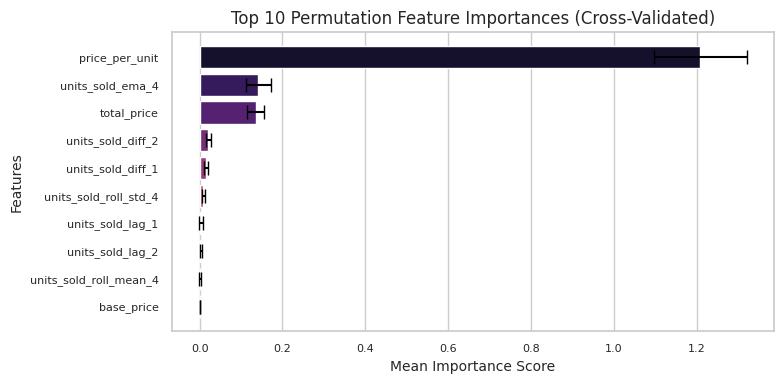


Permutation Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,price_per_unit,1.209109,0.111709
1,units_sold_ema_4,0.141869,0.030125
2,total_price,0.135932,0.020666
3,units_sold_diff_2,0.020811,0.006284
4,units_sold_diff_1,0.015328,0.004811
5,units_sold_roll_std_4,0.009166,0.004319
6,units_sold_lag_1,0.004167,0.004417
7,units_sold_lag_2,0.003405,0.002105
8,units_sold_roll_mean_4,0.001411,0.002468
9,base_price,0.001132,0.000239




===== Permutation Feature Importance for LightGBM Optuna Tuned =====
Processing Fold 1/5
Fold 1 Permutation Importances Extracted.

Processing Fold 2/5
Fold 2 Permutation Importances Extracted.

Processing Fold 3/5
Fold 3 Permutation Importances Extracted.

Processing Fold 4/5
Fold 4 Permutation Importances Extracted.

Processing Fold 5/5
Fold 5 Permutation Importances Extracted.



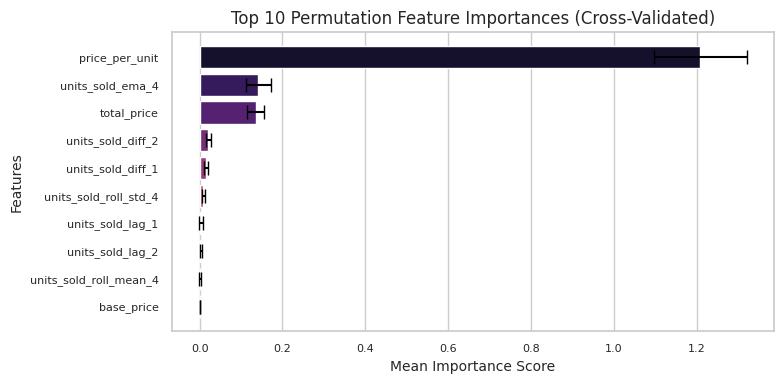


Permutation Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,price_per_unit,1.209076,0.111620
1,units_sold_ema_4,0.141792,0.030104
2,total_price,0.135900,0.020628
3,units_sold_diff_2,0.020723,0.006235
4,units_sold_diff_1,0.015352,0.004843
5,units_sold_roll_std_4,0.009200,0.004383
6,units_sold_lag_1,0.004162,0.004409
7,units_sold_lag_2,0.003404,0.002096
8,units_sold_roll_mean_4,0.001410,0.002483
9,base_price,0.001131,0.000235




===== Permutation Feature Importance for LightGBM GA Tuned =====
Processing Fold 1/5
Fold 1 Permutation Importances Extracted.

Processing Fold 2/5
Fold 2 Permutation Importances Extracted.

Processing Fold 3/5
Fold 3 Permutation Importances Extracted.

Processing Fold 4/5
Fold 4 Permutation Importances Extracted.

Processing Fold 5/5
Fold 5 Permutation Importances Extracted.



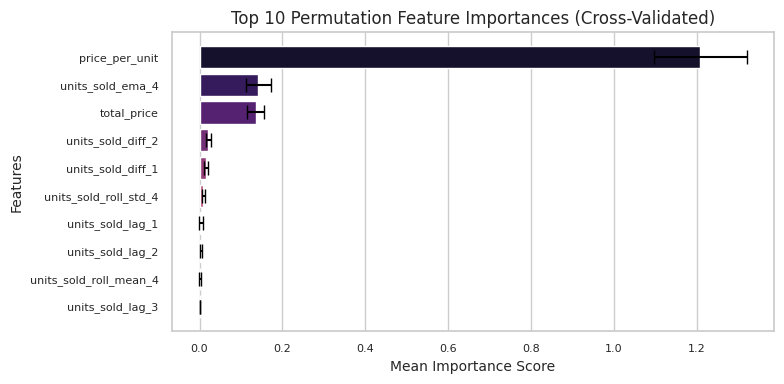


Permutation Feature Importances (Mean and Std) Across Folds:


,Feature,Mean Importance,Std
0,price_per_unit,1.209275,0.111632
1,units_sold_ema_4,0.141866,0.030117
2,total_price,0.136027,0.020716
3,units_sold_diff_2,0.020802,0.006279
4,units_sold_diff_1,0.015283,0.004810
5,units_sold_roll_std_4,0.009158,0.004301
6,units_sold_lag_1,0.004173,0.004413
7,units_sold_lag_2,0.003402,0.002096
8,units_sold_roll_mean_4,0.001411,0.002463
9,units_sold_lag_3,0.001125,0.000275


In [83]:
# Cross-validated permutation importance for tuned models
for model_name in tuned_models:
    if model_name in models:
        print(f"===== Permutation Feature Importance for {model_name} =====")
        permutation_feature_importance(
            model_pipeline=models[model_name],
            X=X_train,
            y=y_train,
            cv_splits=5,
            top_n=10
        )